# Телекоммуникации: прогнозирование оттока клиентов

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание услуг**

Оператор предоставляет два основных типа услуг:
* Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
* Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных**
Данные состоят из файлов, полученных из разных источников:
* `contract_new.csv` — информация о договоре;
* `personal_new.csv` — персональные данные клиента;
* `internet_new.csv` — информация об интернет-услугах;
* `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец 'customerID' содержит код клиента.

**Цель проекта:** построить модель, которая позволит прогнозировать отток клиентов оператора связи «Ниединогоразрыва.ком» и вовремя и адресно предлагать промокоды и специальные условия для удержания клиентов.


**План работ:**


* *1 этап: план и исследовательский анализ данныз*
  * *Загрузка и изучение данных*. Составление представления об объеме и качестве данных. Выявление проблем (несоответствующие типы данных, возможные пропуски, дубликаты или их отсутстствие) и обозначение путей их решения на этапе предобработки данных).
  * *Предобработка данных*. Приведение данных к подходяцим типам, устранение ошибок (например, в столбце 'TotalCharges'), добавление столбцов (целевой признак и дополнительные признаки, например, длительность действия договора), объединение таблиц, устранение пропусков.
  *  *Исследовательский анализ данных*. Анализ распределения признаков. Анализ распределения признаков в связи со значениями целевого признака. Рассмотрение корреляции признаков и борьба с коллинеарностью.
  
    
* *2 этап: построение модели*
  *  *Подготовка данных к обучению*. Выделение признаков и целевого признаков. Разделение данных на обучающую и тестовую выборки в пропорции 3:1. Кодирование признаков (OHE для категориальных, масштабирование для численных), кодируем раздельно обучающую (fit_transform) и тестовую (transform) выборки.   
  * *Обучение моделей и выбор лучшей модели*. Обучение моделей (дерево решений и/или случайный лес, 1-2 бустинга, логистическая регрессия) с различными гиперпараметрами. Оценка качества моделей на кросс-валидации (планируется использование GridSearchCV) и построение сравнительной таблицы, которая должна включать название модели, гиперпараметры, при которых модель показала лучший результат, лучший результат (значение метрики AUC-ROC).
  * *Тестирование лучшей модели.* Метрика AUC-ROC и дополнительно Accuracy(+проверка на адекватность путем сравнения с константной моделью)
  * *Построение матрицы ошибок* (confusion_matrix) и ее интерпретация.
  * *Оценка важности признаков*
    
    
* *3 этап: отчет по проекту*
  * *Подведение итогов проекта:* описание хода работы (в т.ч. предобработки данных отбора признаков, анализ соответствия результатов плану, сравнение рассмотренных моделей, описание лучшей модели с гиперпараметрами и ее результат на тестовой выборке и т.д.

## Этап 1

### Загрузка и изучение данных

Импортируем необходимые на данном этапе библиотеки и модули.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
import phik
import shap

from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

RANDOM_STATE = 70823

Сохраним данные CSV-файлов в переменных. Поскольку у нас 4 файла, с которыми нужно произвести одинаковые действия, создадим функцию `csv_reader()`, которая принимает на вход название файла и загружает данные файла с данным названием из указанной папки.

In [2]:
def csv_reader(file_name):
    try:
        data = pd.read_csv('/datasets/' + file_name + '.csv')
    except:
        data = pd.read_csv('https://code.s3.yandex.net/datasets/' + file_name + '.csv')
    return data

Загрузим данные при помощи функции `csv_reader()`.

In [3]:
contract = csv_reader('contract_new')
personal = csv_reader('personal_new')
internet = csv_reader('internet_new')
phone = csv_reader('phone_new')

Создадим функцию `data_overview()`, которая выведет для каждого объекта `pd.DataFrame` пять первых строк датафрейма, размер, информацию о датафрейме, описательную статистику и количество полных дубликатов.

In [4]:
def data_overview(data):
    display(data.head(5))
    display(data.shape)
    display(data.info())
    display(data.describe())
    print(f"Количество дубликатов: {data.duplicated().sum()}")

#### Данные о договоре

In [5]:
data_overview(contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


(7043, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


Количество дубликатов: 0


**Первый взгляд на данные о договоре позволяет заключить следующее:**

1. Датафрейм состоит из 7043 строк и 8 столбцов.
2. В данных отсутствуют пропуски.
3. Для некоторых столбцов следует поменять типы данных: `BeginDate` и `EndDate` на `datetime`, `TotalCharges` - на `float`.
4. Целевой признак можно получить из значений столбца `EndDate`: если указана дата, клиент ушел из компании.
5. Срок действия договора можно получить из разницы `BeginDate` и `EndDate`. Если в `EndDate` значение `No`, то вместо даты окончания договора укажем дату выгрузки.

#### Персональные данные

In [6]:
data_overview(personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


(7043, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Количество дубликатов: 0


Посчитает количество совпадений значений столбца 'customerID' в таблицах `contract` и `personal`. Поскольку для следующих таблиц будем повторять это действие, напишем функцию, возвращающую количество совпадений совпадений значений столбца 'customerID' в двух таблицах.

In [7]:
def count_shared_ids (data1, data2):
    shared_ids = data1['customerID'].isin(data2['customerID']).sum()
    return shared_ids

In [8]:
count_shared_ids(contract, personal)

7043

**Первый взгляд на персональные данные позволяет заключить следующее:**

1. Датафрейм состоит из 7043 строк (столько же, сколько в данных о договоре) и 5 столбцов. Значения 'customerID' в таблицах `contract` и `personal` совпадают.
2. В данных отсутствуют пропуски.
3. В столбце `SeniorCitizen` тип данных `float`, который плохо подходит для категориальных признаков, следует изменить тип данных.

#### Информация об интернет-услугах

In [9]:
data_overview(internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


(5517, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Количество дубликатов: 0


In [10]:
count_shared_ids(contract, internet)

5517

**Первый взгляд на данные об использовании интернета позволяет заключить следующее:**
1. Датафрейм состоит из 5517 строк и 8 столбцов. Строк меньше, чем в таблицах с данными, при этом все значения `customerID` имеют соответствия в таблице `contract`.  При объединении таблиц будут пропуски, которые нужно будет обработать.
2. Все признаки категориальные.

#### Информация об услугах телефонии

In [11]:
data_overview(phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


(6361, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


Количество дубликатов: 0


In [12]:
count_shared_ids(contract, phone)

6361

**Первый взгляд на данные об использовании услуг телефонии позволяет заключить следующее:**
1. Датафрейм состоит из 6361 строк и 2 столбцов. Строк меньше, чем в таблицах с данными, при этом все значения `customerID` имеют соответствия в таблице `contract`. При объединении таблиц будут пропуски, которые нужно будет обработать.
2. Все признаки категориальные.

#### Количество пользователей интернет-услуг и телефонии

Предположим, что отсутствие данных о пользовании интернет-услугами и услугами телефонии для ряда пользователей означает, что они этими услугами не пользовались. Тогда при помощи функции `count_shared_ids()` можно вычислить количество пользователей, которые пользовались и интернет-услугами, и телефонией, а также либо только интернет-услугами, либо телефонией.

*Количество пользователей как интернет-услуг, так и телефонии*

In [13]:
count_shared_ids(internet, phone)

4835

4835 клиентов пользуются как услугами интернета, так и телефонии.

*Количество пользователей только интернет-услуг*

In [14]:
count_shared_ids(contract, phone) - count_shared_ids(internet, phone)

1526

1526 клиентов пользуются только интернет-услугами.

*Количество пользователей только услуг телефонии*

In [15]:
count_shared_ids(contract, internet) - count_shared_ids(internet, phone)

682

682 клиентов пользуются только услугами телефонии.

Проверим, что полученные числа дают в сумме общее количество пользователей.

In [16]:
count_shared_ids(internet, phone) + (
    count_shared_ids(contract, phone) -
    count_shared_ids(internet, phone)) + (
    count_shared_ids(contract, internet) -
    count_shared_ids(internet, phone))

7043

**Выводы:**
1. Данные содержат информацию о 7043 клиентах компании. При этом данные о договоре и персональные данные есть для всех этих пользователей, а информация об использовании интернет-услуг и телефонии для ряда пользователей отсутствует, что может означать, что некоторые пользователи не пользовались этими услугами.
2. В данных отсутствуют дубликаты.
3. В данных отсутствуют пропуски, но они появятся при объединении таблиц. Эти пропуски нужно обработать таким образом, чтобы было понятно, что пользователь не пользуется определенной услугой в связи с тем, что не пользуется всем пакетом.
4. Для ряда столбцов ('BeginDate', 'EndDate', 'TotalCharges' в таблице `contract`, 'SeniorCitizen' в таблице `personal`) требуется изменения типа данных.
5. Целевой признак (ушел клиент или нет) можно получить из значений столбца 'EndDate'. Из значений столбцов 'BeginDate' и 'EndDate' можно узнать срок действия договора на день выгрузки. Также можно добавить столбцы, эксплицитно показывающие, пользуется клиент конкрентым пакетом услуг (интернет-услуги и телефония).

### Предобработка данных

#### 'TotalCharges'

Столбец 'TotalCharges' имеет тип 'object' и содержит нечисловые значения, до устранения которых невозможно изменить тип данных на численный (код выдает ошибку). Чтобы выявить нечисловые значения в столбце 'TotalCharges', выведем уникальные значения столбца.

In [17]:
contract['TotalCharges'].value_counts()

           11
20.45       6
101.0       5
21.53       4
40.1        4
           ..
4357.5      1
3509.55     1
2530.8      1
2599.1      1
7251.82     1
Name: TotalCharges, Length: 6658, dtype: int64

В 11 случаях видим, что значение в столбце 'TotalCharges' отсутствует. Но это не пропуск, опытным путем удается установить, что там "скрывается" пробел. Посмотрим на эти 11 строк.

In [18]:
contract[contract['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Все договоры заключены в день выгрузки. Это новые клиенты, для которых факт оплаты мог не успел зафиксироваться. Будем считать, что при заключении договора клиент обязательно заплатит за первый месяц, тогда заменим пробел в столбце 'TotalCharges' на значение ежемесячного платежа.

In [19]:
contract.loc[contract['TotalCharges'] == ' ', 'TotalCharges'] = contract['MonthlyCharges']

Проверим результат.

In [20]:
contract[contract['BeginDate'] == '2020-02-01']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,52.55
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,20.25
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,80.85
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,25.75
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,56.05
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,19.85
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,25.35
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,20.0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,19.7
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,73.35


In [21]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Теперь поменяем тип данных в столбце на `float`.

In [22]:
contract['TotalCharges'] = contract['TotalCharges'].astype('float')

In [23]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


#### 'BeginDate' и 'EndDate'

Перед тем как преобразовать тип столбца 'EndDate' в datetime, создадим целевой признак 'Churn' (англ. «отток клиентов») путем сравнения значений в 'EndDate' с 'No'. Если значение в столбце 'EndDate' равно 'No', значит клиент не ушел (а если не равно 'No', значит ушел). Булев тип данных преобразуем в целочисленный.

In [24]:
contract['Churn'] = (contract['EndDate'] != 'No').astype('int')

Выведем 5 строк полученного датафрейма

In [25]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,0


Тип данных в столбце 'EndDate' невозможно преобразовать в datetime, пока в нем есть значение 'No'. С учетом того, что далее мы будем определять срок действия договора на день выгрузки данных, все значения 'No' можем поменять на дату выгрузки ('2020-02-01'). Изменение 'No' на дату выгрузки не приведет к искажению данных и будет обратимо, поскольку ни один клиент в действительности покинул компанию в этот день.

In [26]:
contract[contract['EndDate'] == '2020-02-01']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [27]:
contract['EndDate'] = contract['EndDate'].replace('No', '2020-02-01')

Теперь поменяем тип данных в столбцах 'BeginDate' и 'EndDate' на datetime.

In [28]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d')

Теперь посчитаем срок действия договора. Для действующих договоров датой окончания условно будем считать дату выгрузки. Мне сначала показалось логичным считать срок действия договора в месяцах: во-первых, услуги тарифицируются помесячно (есть столбец 'MonthlyCharges'), во-вторых, можно заметить что все даты начала и окончания действия договора приходятся на первое число месяца (см. ниже).

Число начало договора:

In [29]:
contract['BeginDate'].dt.day.value_counts()

1    7043
Name: BeginDate, dtype: int64

Число окончания договора (в том числе для клиентов, покинувших компанию до даты выгрузки данных):

In [30]:
contract['EndDate'].dt.day.value_counts()

1    7043
Name: EndDate, dtype: int64

Пять строк с положительным значением признака 'Churn' (см. столбец 'EndDate'):

In [31]:
contract[contract['Churn'] == 1].head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,1
15,3655-SNQYZ,2014-05-01,2016-03-01,Two year,No,Credit card (automatic),113.25,2491.50,1
25,6865-JZNKO,2017-08-01,2018-09-01,Month-to-month,Yes,Bank transfer (automatic),55.30,726.09,1
30,3841-NFECX,2014-03-01,2018-11-01,Two year,Yes,Credit card (automatic),96.35,5395.60,1
35,6234-RAAPL,2014-02-01,2018-12-01,Two year,No,Bank transfer (automatic),99.90,5794.20,1


Однако при дальнейшей работе выяснилось, что срок договора в днях дает более точные данные, которые лучше подходят для обучения. Кроме того, было получено пояснение, что для многих договоров была неизвестна дата, и 'No' заменили на первое число месяца. Добавим столбец 'ContractDuration', содержащий длительность действия договора в днях.

In [32]:
contract['ContractDuration'] = (contract['EndDate'] - contract['BeginDate']).dt.days

Пять строк полученного датасета.

In [33]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ContractDuration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153


#### 'SeniorCitizen'

Данные в столбце 'SeniorCitizen' таблицы `personal` имеют тип `float`, в то время как это бинарный категориальный признак. Изменить тип данных можно разными способами, в том числе, например, поменяв тип данных на object.

In [34]:
personal['SeniorCitizen'] = personal['SeniorCitizen'].astype('object')

Проверим результат при помощи функции `data_overview()`.

In [35]:
data_overview(personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


(7043, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043,7043,7043
unique,7043,2,2,2,2
top,7590-VHVEG,Male,0,No,No
freq,1,3555,5901,3641,4933


Количество дубликатов: 0


Теперь данные во всех столбцах имеют тип object, а метод `describe()` выводит данные о количестве классов и числе объектов более частотного класса.

#### Пользование пакетами услуг

Добавим в таблицы internet и phone столбцы 'Internet' и 'Phone' соответственно, заполнив их положительным значением признака ('Yes'), указывающим, что клиент пользуется пакетом услуг (интернет-услуги и телефония). Далее при объединении таблиц образовавшиеся пропуски заполним отрицательным значением ('No').

In [36]:
internet['Internet'] = 'Yes'
phone['Phone'] = 'Yes'

In [37]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Internet
0,7590-VHVEG,DSL,No,Yes,No,No,No,No,Yes
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No,Yes
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No,Yes
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No,Yes
4,9237-HQITU,Fiber optic,No,No,No,No,No,No,Yes


In [38]:
phone.head()

,customerID,MultipleLines,Phone
0,5575-GNVDE,No,Yes
1,3668-QPYBK,No,Yes
2,9237-HQITU,No,Yes
3,9305-CDSKC,Yes,Yes
4,1452-KIOVK,Yes,Yes


#### Объединение таблиц

Объединим таблицы методом `merge()` по столбцу 'customerID', присоединив таблицы `personal`, `internet` и `phone` к таблице `contract`, содержащей данные о всех 7043 пользователях.

In [39]:
data = contract.merge(personal, on='customerID', how='left').merge(
    internet, on='customerID', how='left').merge(phone, on='customerID', how='left')

Проверим результат объединения таблиц при помощи функции `data_overview()`

In [40]:
data_overview(data)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ContractDuration,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Internet,MultipleLines,Phone
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,Yes,NaN,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,Yes,No,Yes
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,Yes,No,Yes
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,Yes,NaN,NaN
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,0,No,No,Fiber optic,No,No,No,No,No,No,Yes,No,Yes


(7043, 24)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int64         
 9   ContractDuration  7043 non-null   int64         
 10  gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   object        
 12  Partner           7043 non-null   object        
 13  Dependents        7043 non-null   object        
 14  InternetService   5517 n

None

,MonthlyCharges,TotalCharges,Churn,ContractDuration
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.377573,0.156325,898.555729
std,30.090047,2112.678861,0.363189,683.130510
min,18.250000,19.050000,0.000000,0.000000
25%,35.500000,436.750000,0.000000,276.000000
50%,70.350000,1343.350000,0.000000,761.000000
75%,89.850000,3236.690000,0.000000,1461.000000
max,118.750000,9221.380000,1.000000,2314.000000


Количество дубликатов: 0


В получившейся таблице 24 столбца и 7043 строки. В таблицу попали данные обо всех клиентах. Пропуски образовались именно там, где это ожидалось: в столбцах, полученных из таблиц `internet` и `phone`.

Заполним пропуски в столбцах 'Internet' и 'Phone' на 'No', поскольку они означают, что клиенты не пользуются этими пакетами услуг. Остальные пропуски обозначим 'Not relevant' - эти пропуски связаны с тем, что клиент не пользуется всем пакетом.

In [41]:
data[['Internet', 'Phone']] = data[['Internet', 'Phone']].fillna('No')

In [42]:
data = data.fillna('Not relevant')

Еще раз применим функцию `data_overview()`

In [43]:
data_overview(data)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ContractDuration,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Internet,MultipleLines,Phone
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,Yes,Not relevant,No
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,Yes,No,Yes
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,Yes,No,Yes
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,Yes,Not relevant,No
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,0,No,No,Fiber optic,No,No,No,No,No,No,Yes,No,Yes


(7043, 24)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int64         
 9   ContractDuration  7043 non-null   int64         
 10  gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   int64         
 12  Partner           7043 non-null   object        
 13  Dependents        7043 non-null   object        
 14  InternetService   7043 n

None

,MonthlyCharges,TotalCharges,Churn,ContractDuration,SeniorCitizen
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.377573,0.156325,898.555729,0.162147
std,30.090047,2112.678861,0.363189,683.130510,0.368612
min,18.250000,19.050000,0.000000,0.000000,0.000000
25%,35.500000,436.750000,0.000000,276.000000,0.000000
50%,70.350000,1343.350000,0.000000,761.000000,0.000000
75%,89.850000,3236.690000,0.000000,1461.000000,0.000000
max,118.750000,9221.380000,1.000000,2314.000000,1.000000


Количество дубликатов: 0


После заполнения пропусков данные в столбце 'SeniorCitizen' вернулись к типу `int`. Исправим это.

In [44]:
data['SeniorCitizen'] = data['SeniorCitizen'].astype('object')

Можно заметить, что имена двух столбцов ('customerID' и 'gender') начинаются со строчных букв, а имена остальных столбцов – с заглавных. Для единообразия изменим названия этих двух столбцов (по правилам "хорошего стиля" можно было бы перевести все названия в нижний регистр, но поскольку в задачах по машинному обучению, встретившихся в курсе, в основном встречалось именно такое написание названий признаков (с заглавной буквы), не будем переводить названия в нижний регистр).

In [45]:
data = data.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender'})

In [46]:
data.columns

Index(['CustomerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'ContractDuration', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Internet',
       'MultipleLines', 'Phone'],
      dtype='object')

**Выводы**
1. Преобразованы типы данных столбцов 'BeginDate', 'EndDate', 'TotalCharges' и 'SeniorCitizen'.
2. На основании имеющихся данных добавлены признаки 'Churn' (показывающий, ушел ли клиент из компании), 'ContractDuration' (длительность контракта в месяцах), 'Internet' (пользование пакетом интернет-услуг) и 'Phone' (пользование пакетом телефонии).
3. Таблицы объединены. Проверено, что в объединенную таблицу вошли данные обо всех пользователях.
4. Устранены пропуски с учетом данных о пользовании клиентами пакетов и услуг.
5. В объединенной таблице унифицированы названия столбцов.

### Исследовательский анализ данных

В данном разделе проанализируем распределение значений признаков как независимо, так и во взаимодействии с целевым признаком 'Churn'. Среди признаков выделим количественные и категориальные (данное разделение пригодится нам и на следующем этапе работы над проектом, поскольку перед нами не задача на временные ряды, не будем включать даты в число признаков). Также создадим матрицы корреляции признаков для борьбы с коллинеарностью.

In [47]:
num_features = ['MonthlyCharges',
                'TotalCharges',
                'ContractDuration']

cat_features = ['Type',
                'PaperlessBilling',
                'PaymentMethod',
                'Gender',
                'SeniorCitizen',
                'Partner',
                'Dependents',
                'Internet',
                'InternetService',
                'OnlineSecurity',
                'OnlineBackup',
                'DeviceProtection',
                'TechSupport',
                'StreamingTV',
                'StreamingMovies',
                'Phone',
                'MultipleLines']

#### Целевой признак 'Churn'

Построим таблицу и график, показывающие распределение значений целевого признака.

   count  percentage
0   5942   84.367457
1   1101   15.632543


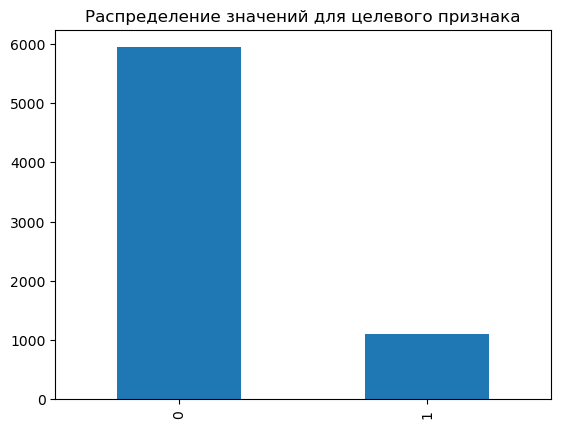

In [48]:
name_counts = data['Churn'].value_counts()
percentage = data['Churn'].value_counts() / len(data) * 100
df = pd.concat([name_counts, percentage], axis= 1 )
df.columns=['count', 'percentage']
print(df)
name_counts.plot(kind='bar', title=f"Распределение значений для целевого признака")
plt.show()

Можно наблюдать дисбаланс классов. Решение о том, что с ним делать будет приниматься далее при решении задачи машинного обучения. Отметим, что целевая метрика `AUC-ROC` нечувствительна к дисбалансу классов.

#### Распределение количественных признаков

Рассмотрим распределение значений в столбцах с количественными признаками

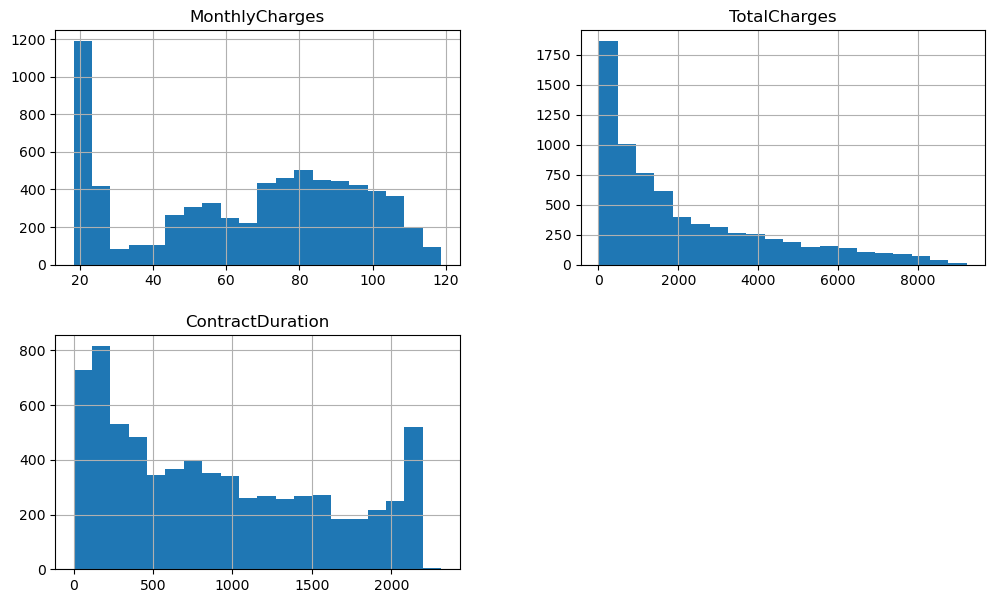

In [49]:
data[num_features].hist(figsize=(12,7), bins=20);

In [50]:
data[num_features].describe()

,MonthlyCharges,TotalCharges,ContractDuration
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.377573,898.555729
std,30.090047,2112.678861,683.130510
min,18.250000,19.050000,0.000000
25%,35.500000,436.750000,276.000000
50%,70.350000,1343.350000,761.000000
75%,89.850000,3236.690000,1461.000000
max,118.750000,9221.380000,2314.000000


1) Ежемесячные траты за пользование услугами находятся в диапазоне между примерно 20 и 120 (валюта в условии не названа, поэтому будем использовать обозначение у.е.). При этом можно заметить, что распределение является биноминальным: можно видеть, что большинство клиентов пользуется минимальным тарифом, но также видно, что много клиентов платят ежемесячно около 80 у.e.
2) Размер общих трат обратно пропорционален количеству клиентов, совершивших эти траты. При том, что максимальный размер общих трат за услуги превышает 9000 у.е., траты половины клиентов не превышают 1400 у.е. Это может быть связано сразу с двумя факторами: с одной стороны, в компании может быть много новых клиентов с небольшим сроком действия договора (пришедшие недавно или ушедшие спустя короткий срок после заключения договора), с другой, - как было отмечено, большинство клиентов предпочитают недорогие тарифы.
3) На гистограмме, показывающей распределение пользователей по сроку действия договора в месяцах, можно заметить пик в районе начала: большая доля пользователей либо в первые несколько месяцев ушли из компании, либо заключили договор недавно. Также наблюдается значительная доля клиентов, которые пользуются услугами компании с самого начала наблюдений. Этот график коррелирует с датами начала пользования услугами (см. ниже): в последние несколько месяцев больше пользователей пришло в компанию, однако также есть пик в феврале-марте 2014 года.

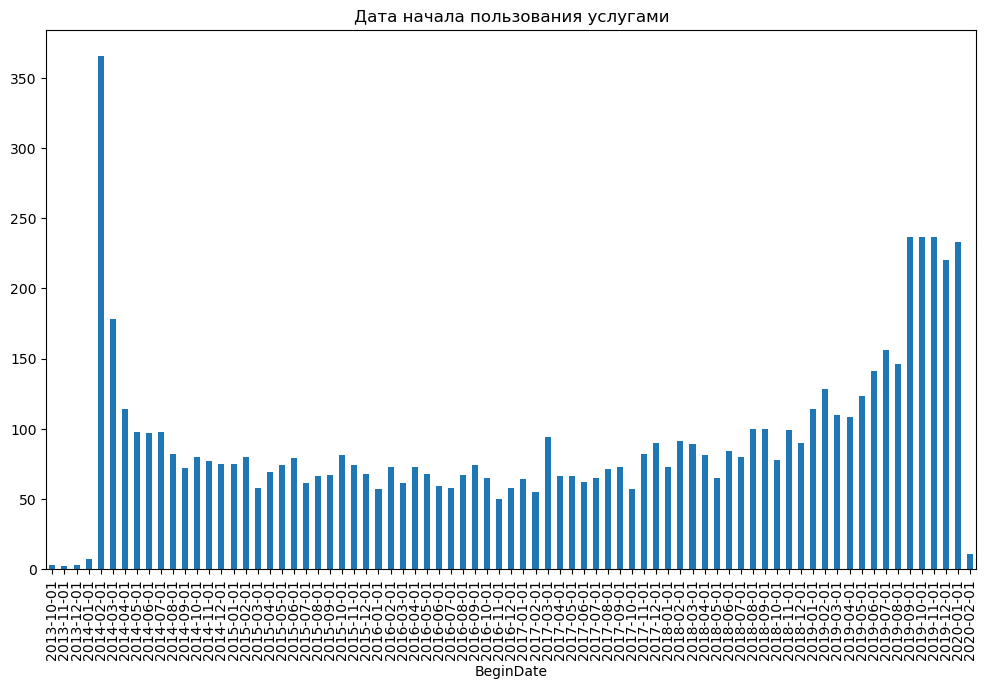

In [51]:
data.pivot_table(index=data['BeginDate'].dt.date,
                values='Type',
                aggfunc='count').plot(kind='bar',
                                       figsize=(12,7),
                                       title='Дата начала пользования услугами',
                                       legend=False);

Посмотрим также на даты ухода клиента из компании.

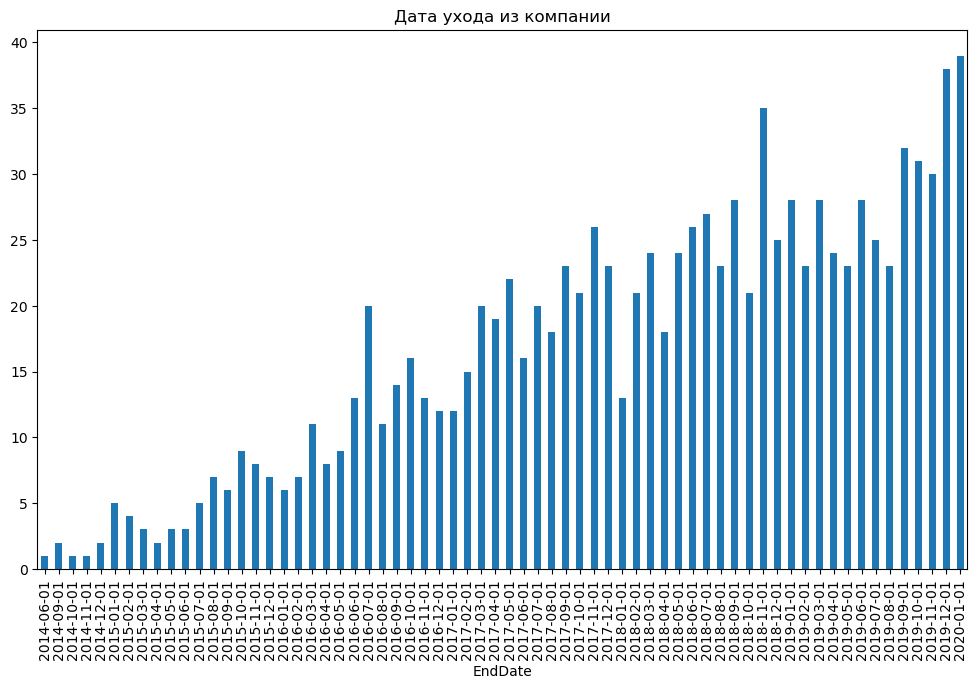

In [52]:
data[data['EndDate']!='2020-02-01'].pivot_table(index=data['EndDate'].dt.date,
                                                values='Type',
                                                aggfunc='count').plot(kind='bar',
                                                                      figsize=(12,7),
                                                                      title='Дата ухода из компании',
                                                                      legend=False);

Оператор связи не зря беспокоится: со временем наблюдается тенденция роста количества клиентов, покинувших компанию.

#### Распределение категориальных признаков

Рассмотрим распределение значений категориальных признаков в выборке.

Признак Type
                count  percentage
Month-to-month   3875   55.019168
Two year         1695   24.066449
One year         1473   20.914383


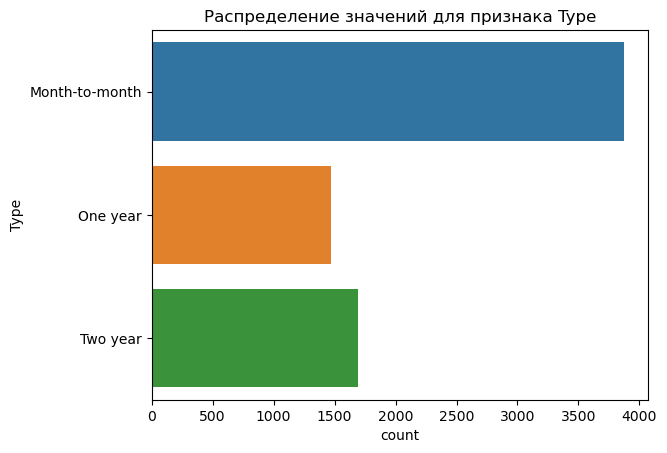

Признак PaperlessBilling
     count  percentage
Yes   4171   59.221922
No    2872   40.778078


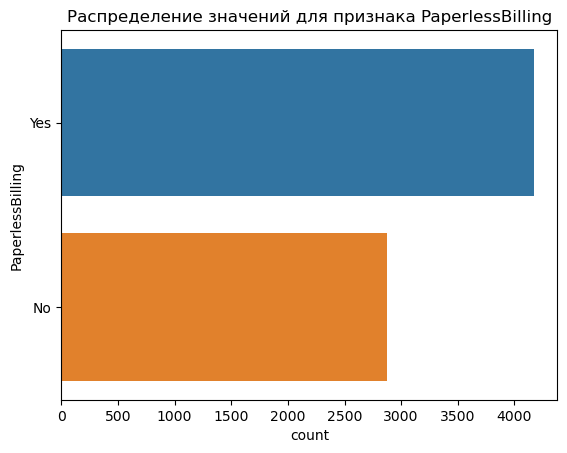

Признак PaymentMethod
                           count  percentage
Electronic check            2365   33.579441
Mailed check                1612   22.887974
Bank transfer (automatic)   1544   21.922476
Credit card (automatic)     1522   21.610109


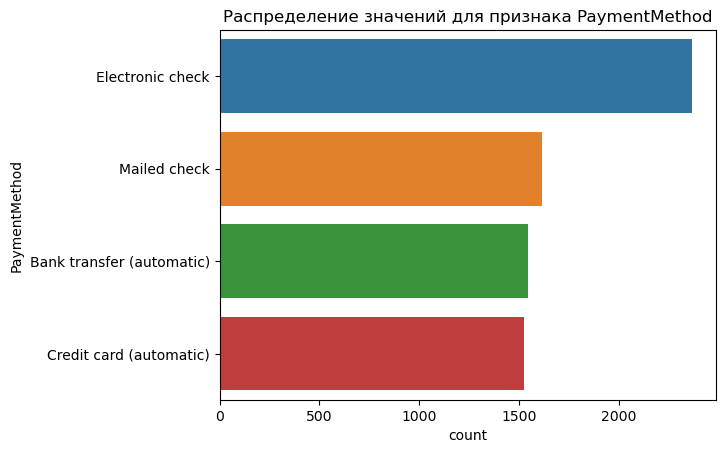

Признак Gender
        count  percentage
Male     3555    50.47565
Female   3488    49.52435


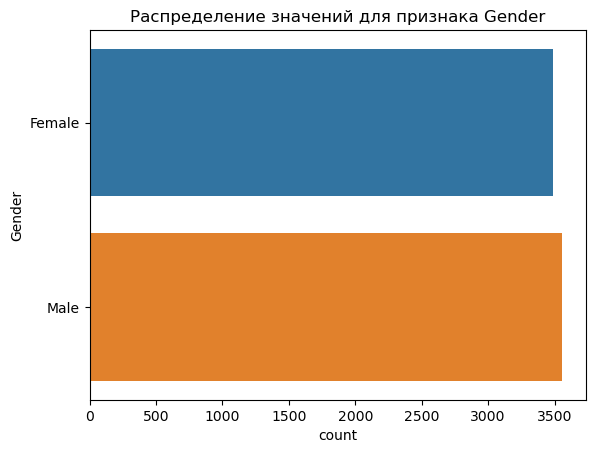

Признак SeniorCitizen
   count  percentage
0   5901   83.785319
1   1142   16.214681


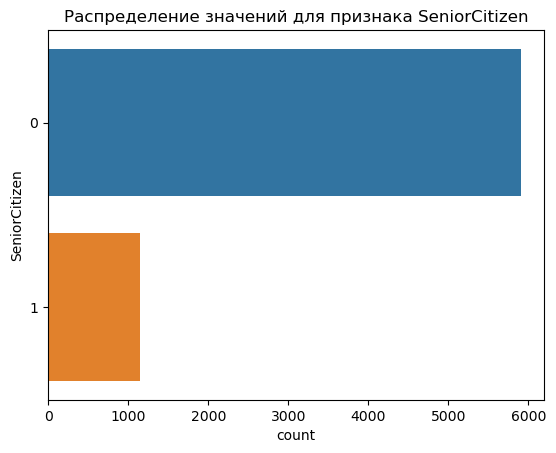

Признак Partner
     count  percentage
No    3641    51.69672
Yes   3402    48.30328


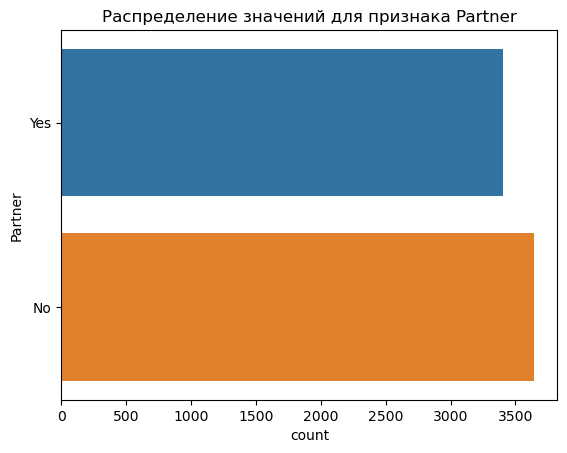

Признак Dependents
     count  percentage
No    4933   70.041176
Yes   2110   29.958824


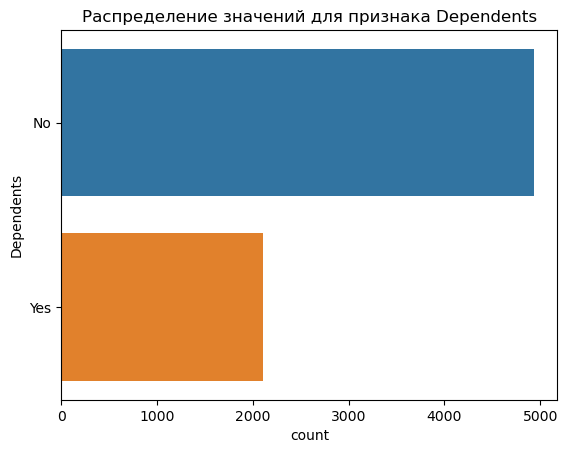

Признак Internet
     count  percentage
Yes   5517   78.333097
No    1526   21.666903


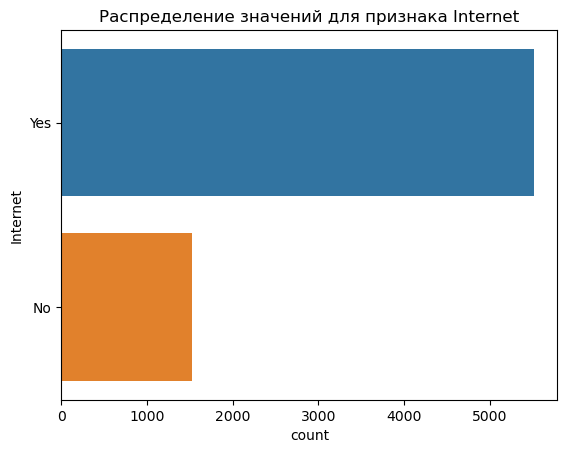

Признак InternetService
              count  percentage
Fiber optic    3096   43.958540
DSL            2421   34.374556
Not relevant   1526   21.666903


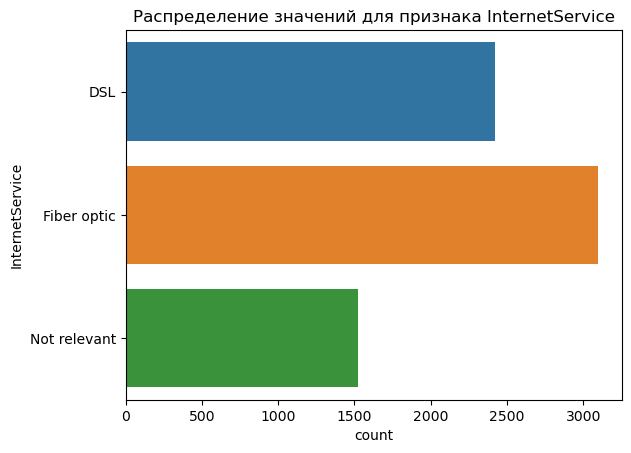

Признак OnlineSecurity
              count  percentage
No             3498   49.666335
Yes            2019   28.666761
Not relevant   1526   21.666903


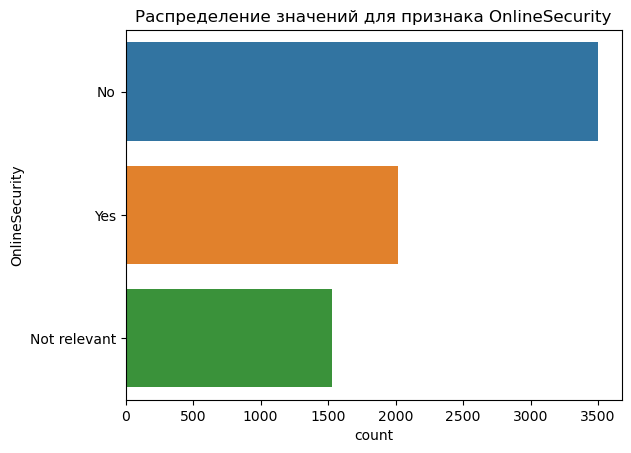

Признак OnlineBackup
              count  percentage
No             3088   43.844952
Yes            2429   34.488144
Not relevant   1526   21.666903


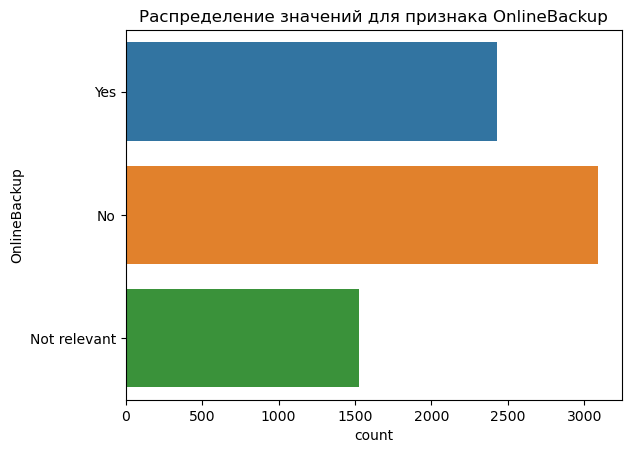

Признак DeviceProtection
              count  percentage
No             3095   43.944342
Yes            2422   34.388755
Not relevant   1526   21.666903


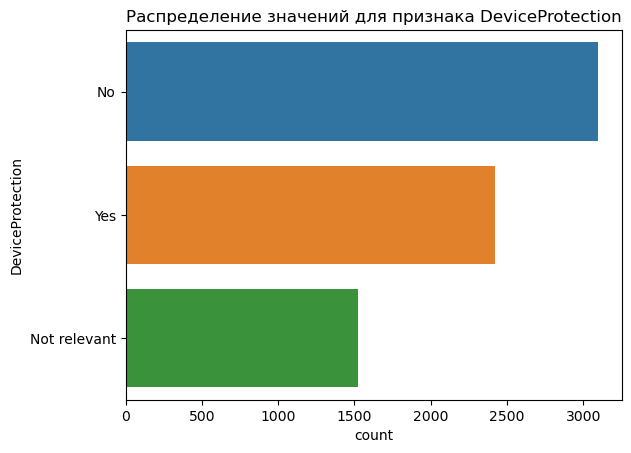

Признак TechSupport
              count  percentage
No             3473   49.311373
Yes            2044   29.021724
Not relevant   1526   21.666903


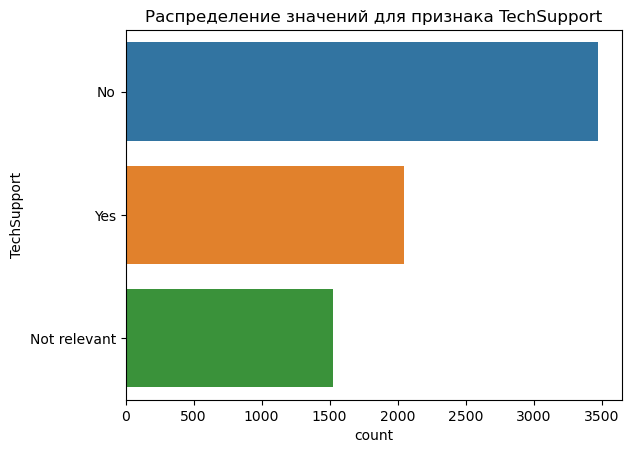

Признак StreamingTV
              count  percentage
No             2810   39.897771
Yes            2707   38.435326
Not relevant   1526   21.666903


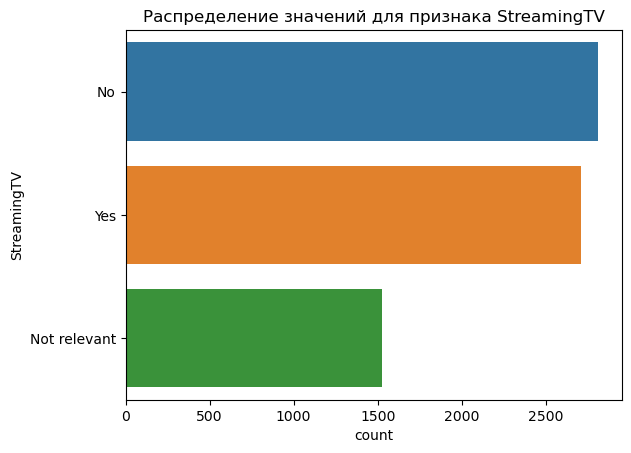

Признак StreamingMovies
              count  percentage
No             2785   39.542808
Yes            2732   38.790288
Not relevant   1526   21.666903


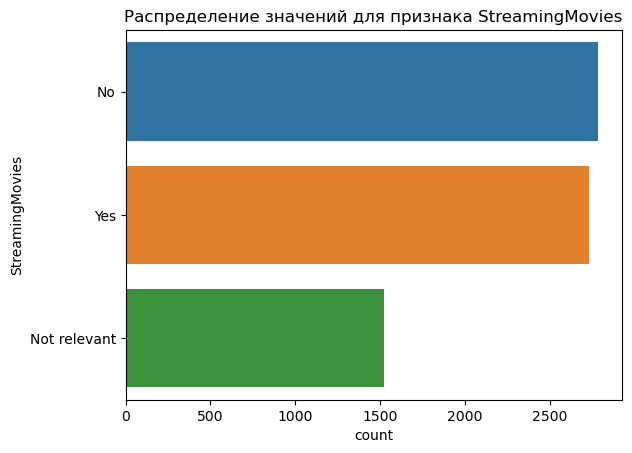

Признак Phone
     count  percentage
Yes   6361   90.316626
No     682    9.683374


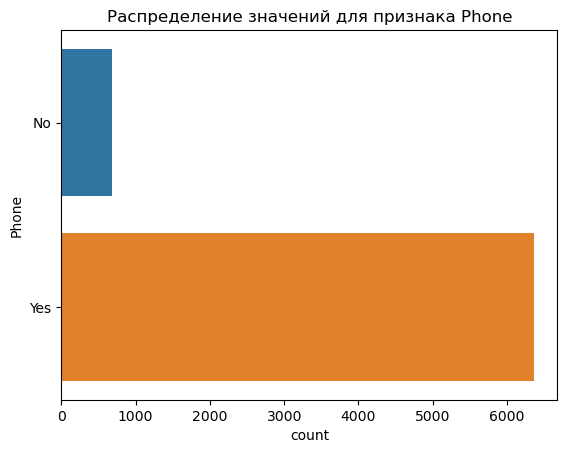

Признак MultipleLines
              count  percentage
No             3390   48.132898
Yes            2971   42.183729
Not relevant    682    9.683374


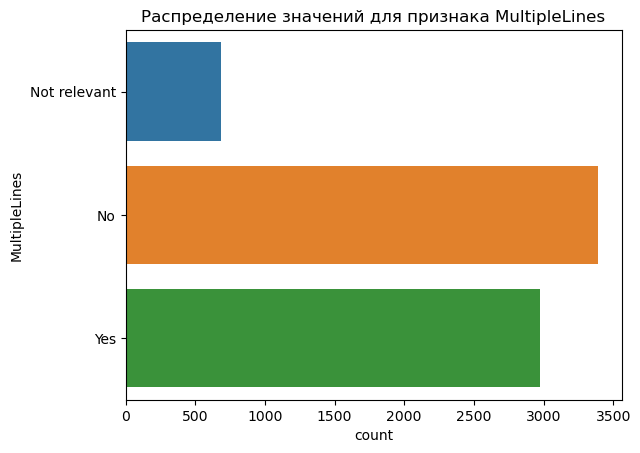

In [53]:
for feature in cat_features:
    name_counts = data[feature].value_counts()
    percentage = name_counts / len(data) * 100
    df = pd.concat([name_counts, percentage], axis= 1 )
    df.columns=['count', 'percentage']
    print(f"Признак {feature}")
    print(df)
    sns.countplot(y=data[feature])
    plt.title(f"Распределение значений для признака {feature}")
    plt.show()

**Краткое описание распределения категориальных признаков**
* Данные о договоре:
    * Большая часть пользователей (около 55%) оплачивают услуги помесячно.
    * Около 60% пользователей предпочитают счета в электронном виде.
    * Предпочтительным способом оплаты (34%) оплаты является электронный чек, остальные способы оплаты пользуются примерно одинаковой популярностью (21-22%).
* Песональные данные:
    * В выборке примерно одинаковое количество клиентов мужского и женского пола.
    * Большинство (84%) пользователей услуг не являются пенсионерами. Поскольку несовершеннолетние не могут заключать договор с опрератором связи, можно сделать вывод, что эти 84% клиентов - люди трудоспособного возраста.
    * Среди клиентов компании примерно одинаковое количество людей, состоящих и не состоящих в браке (одиноких немного больше). (Интересно было бы сравнить распреденение с данными по популяции.)
    * Только у 30% пользователей есть иждивенцы.
* Пользование интернет-услугами:
    * 78% клиентов пользуются интернет-услугами. Среди тех, кто пользуется интернет-услугами:
        * большая часть подключается к интернету через оптоволоконный кабель;
        * большинство не пользуются услугой блокировки небезопасных сайтов;
        * большинство не пользуются облачным хранилищем для резервного копирования данных;
        * большинство не пользуются антивирусом;
        * большинство не пользуются выделенной линией технической поддержки;
        * около половины пользуются стриминговым телевидением;
        * около половины подключены к каталогу фильмов.
* Пользование стационарной телефонной связью:
    * 90% клиентов пользуются услугами телефонии. Среди тех, кто пользуется услугами телефонии:
        * несколько больше пользователей, которые не пользуются услугой подключение телефонного аппарата к нескольким линиям одновременно.
    
Таким образом, большинство пользователей подключают один из пакетов услуг (или оба сразу), но чаще не пользуются дополнительными услугами в рамках пакета.

#### Распределение количественных признаков относительно значений целевого признака

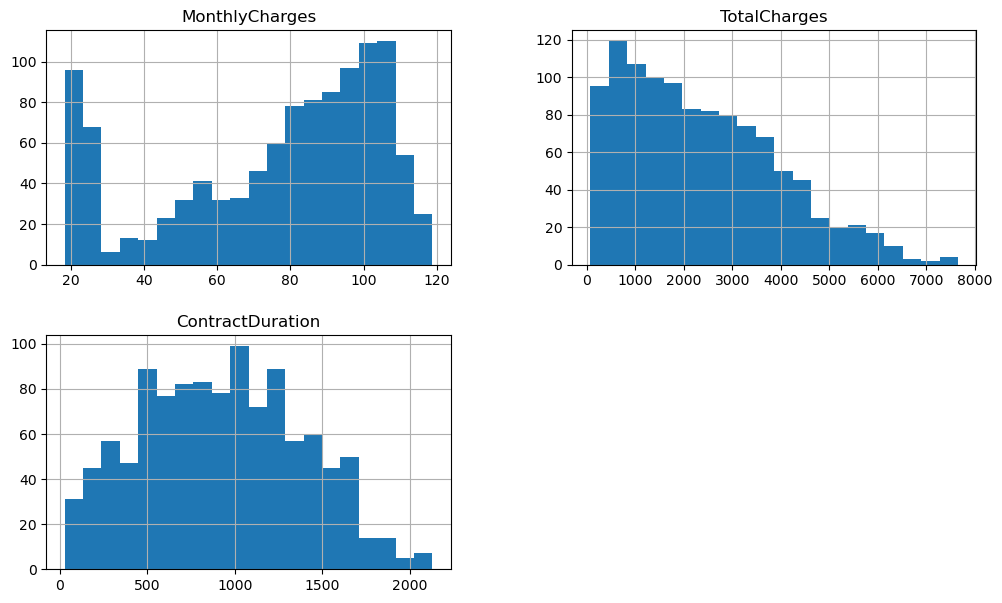

In [54]:
data[data['Churn'] == 1][num_features].hist(figsize=(12,7), bins=20);

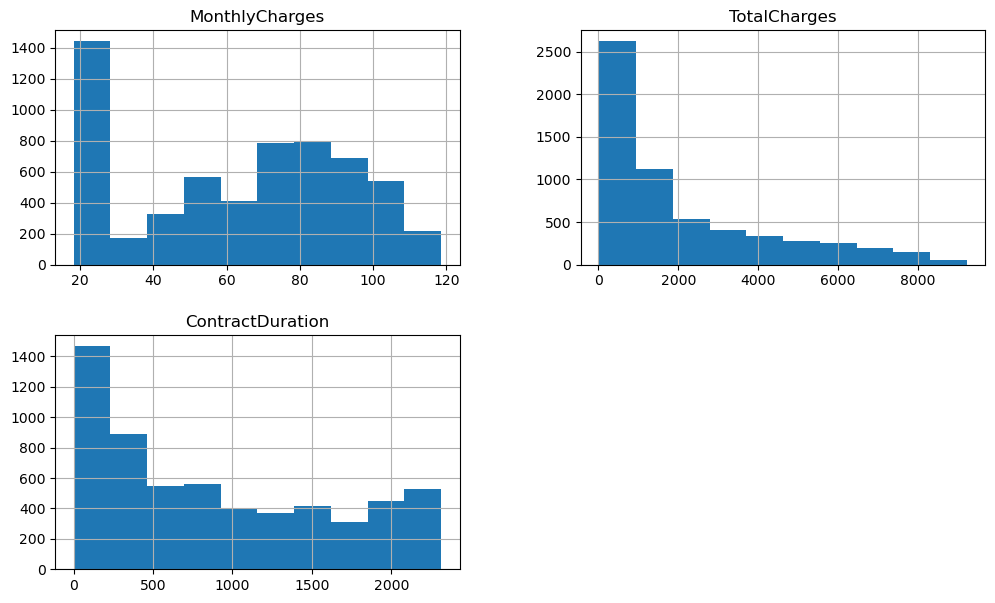

In [55]:
data[data['Churn'] == 0][num_features].hist(figsize=(12,7), bins=10);

* Можно заметить, что среди ушедших много клиентов с высокой ежемесячной платой за услуги (пик около 100, которого нет на общем распределении).
* Распределение сроков действия договоров клиентов, покинувших компанию, близко к нормальному: компанию редко покидают новые клиенты и клиенты, давно (около 5 лет) пользующиеся услугами компании.

#### Распределение категориальных признаков относительно значений целевого признака

Напишем функцию для создания таблицы, показывающей распределение значений каждого категориального признака и значений целевого признака

In [56]:
def value_count_groupedby(df, grouped_col, counted_col):
    g = df.groupby(grouped_col)
    ret = pd.DataFrame()
    for group in g.groups:
        ret[group] = df.iloc[g.groups[group]][counted_col].value_counts()
    return ret

Выведем на экран таблицы и соответствующие им графики.

Признак Type


,0,1
Month-to-month,3468,407
Two year,1314,381
One year,1160,313


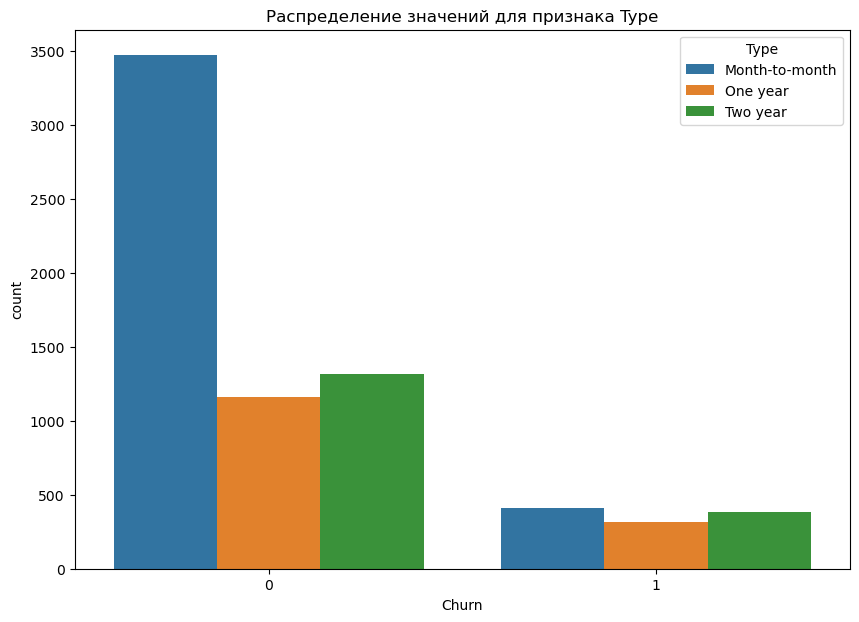

Признак PaperlessBilling


,0,1
Yes,3450,721
No,2492,380


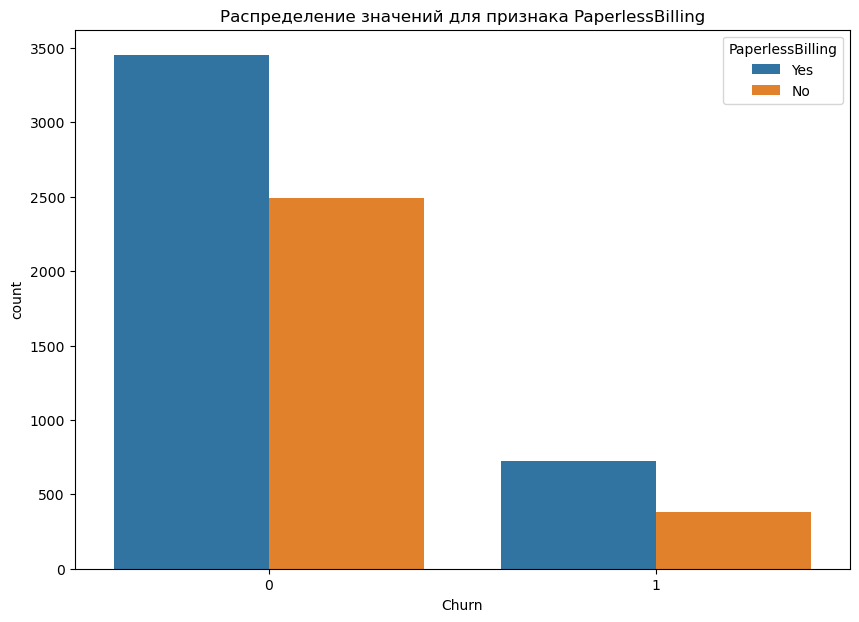

Признак PaymentMethod


,0,1
Electronic check,2015,350
Mailed check,1495,117
Bank transfer (automatic),1227,317
Credit card (automatic),1205,317


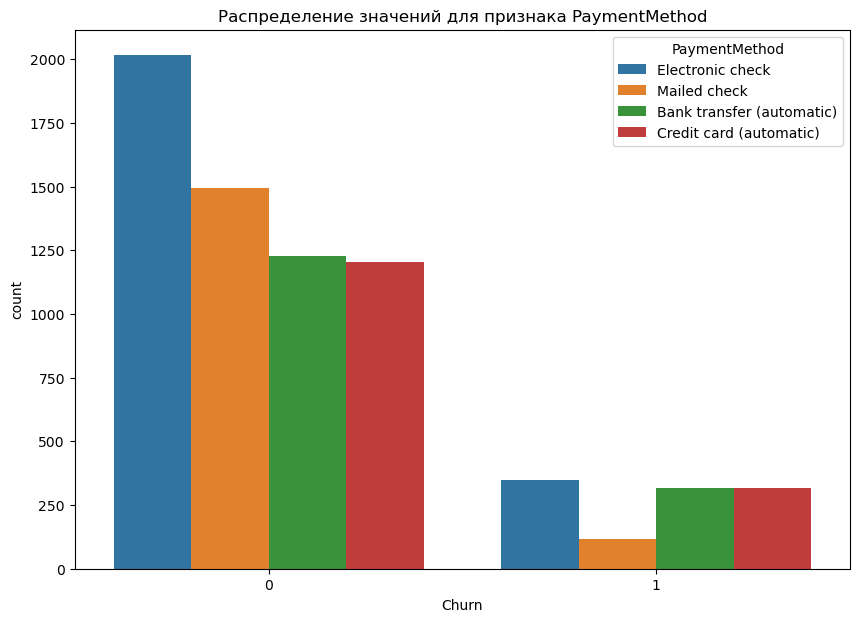

Признак Gender


,0,1
Male,2982,573
Female,2960,528


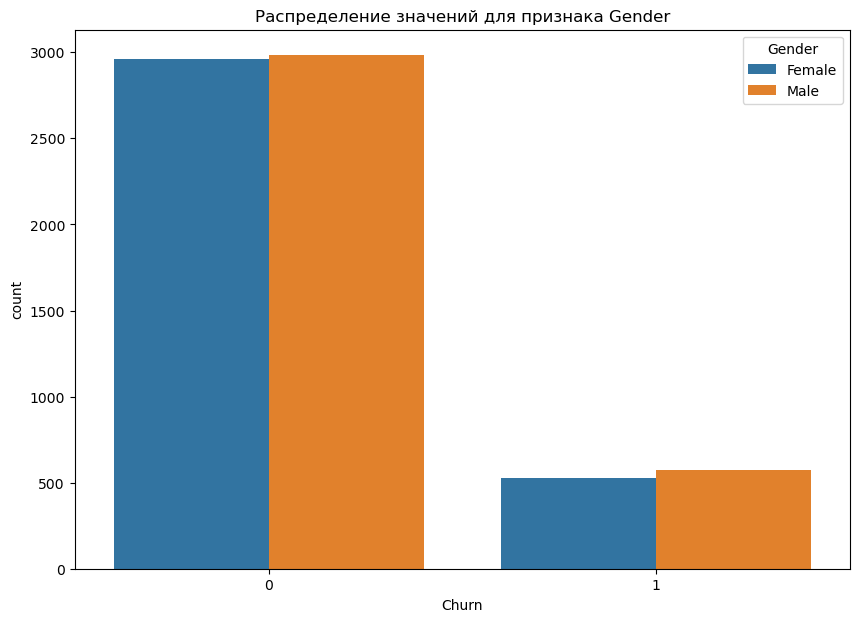

Признак SeniorCitizen


,0,1
0,5032,869
1,910,232


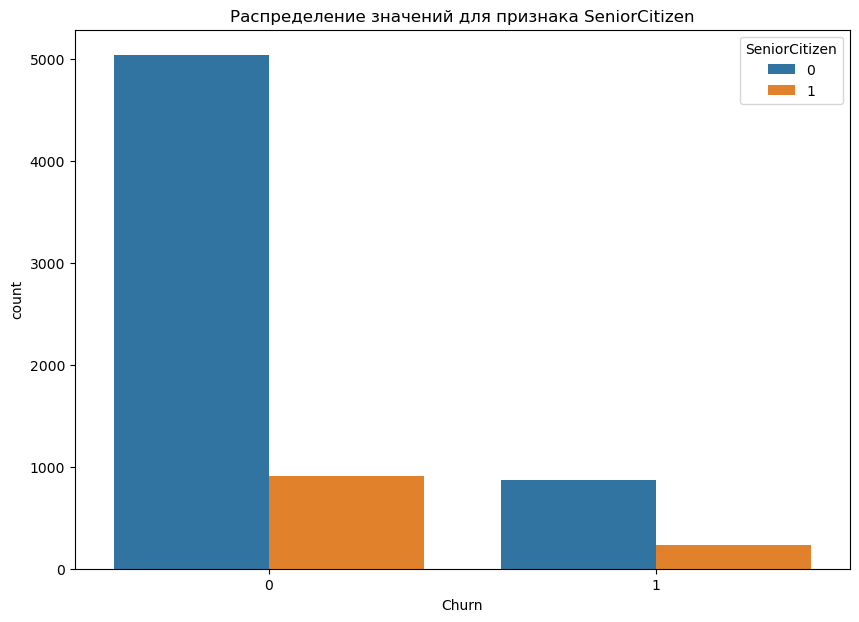

Признак Partner


,0,1
No,3259,382
Yes,2683,719


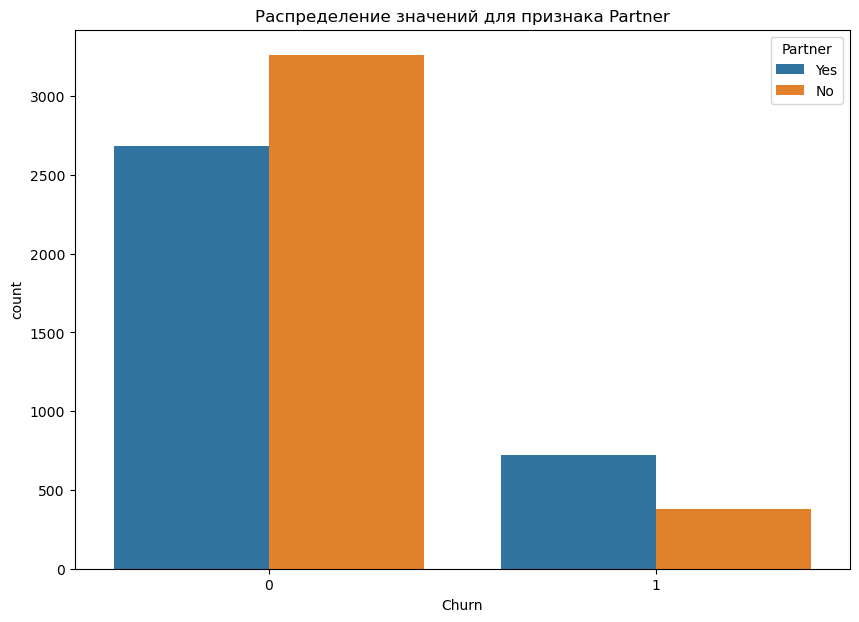

Признак Dependents


,0,1
No,4200,733
Yes,1742,368


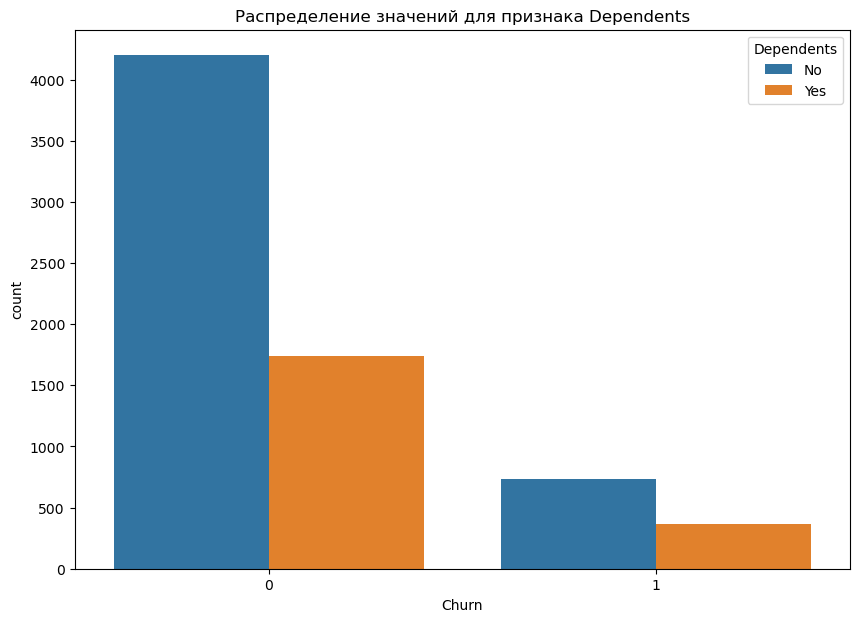

Признак Internet


,0,1
Yes,4576,941
No,1366,160


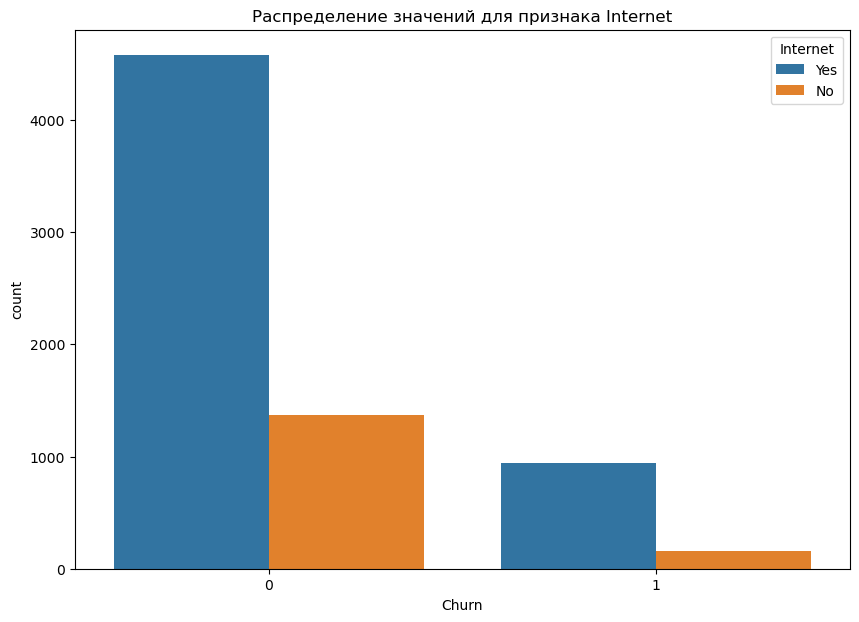

Признак InternetService


,0,1
Fiber optic,2501,595
DSL,2075,346
Not relevant,1366,160


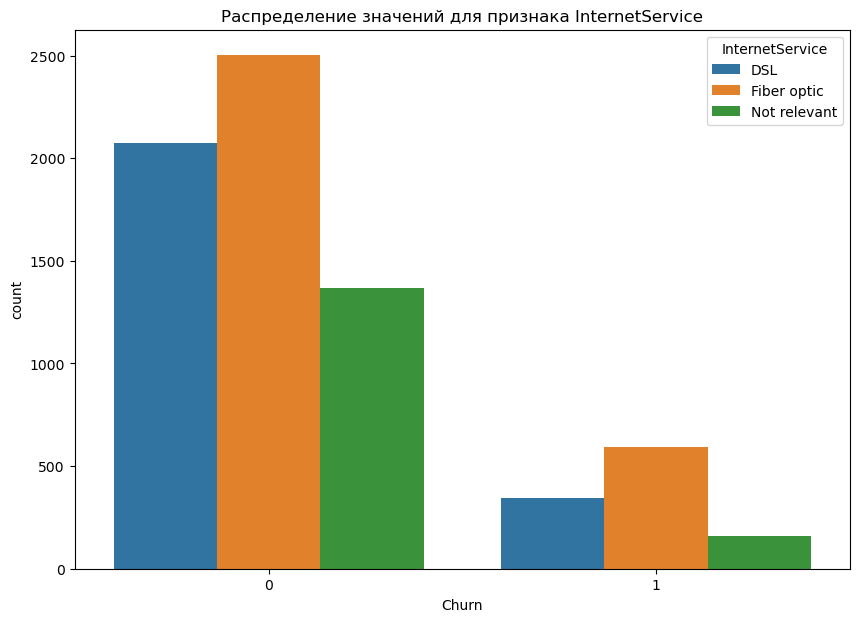

Признак OnlineSecurity


,0,1
No,2972,526
Yes,1604,415
Not relevant,1366,160


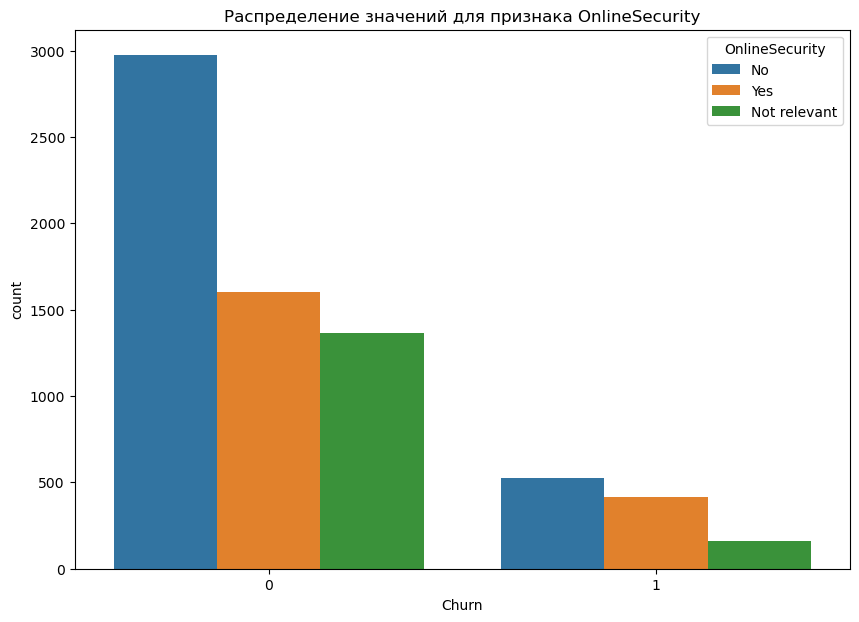

Признак OnlineBackup


,0,1
No,2707,381
Yes,1869,560
Not relevant,1366,160


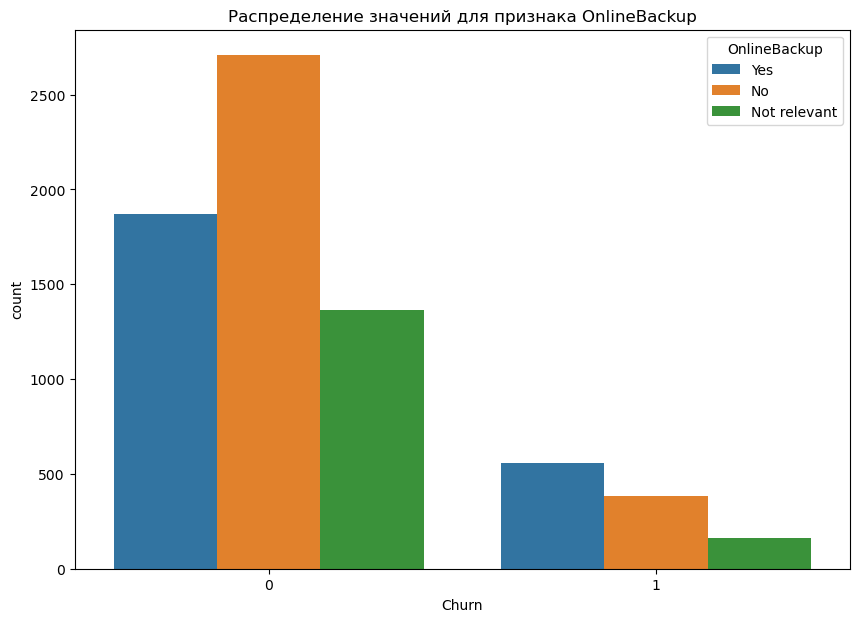

Признак DeviceProtection


,0,1
No,2704,391
Yes,1872,550
Not relevant,1366,160


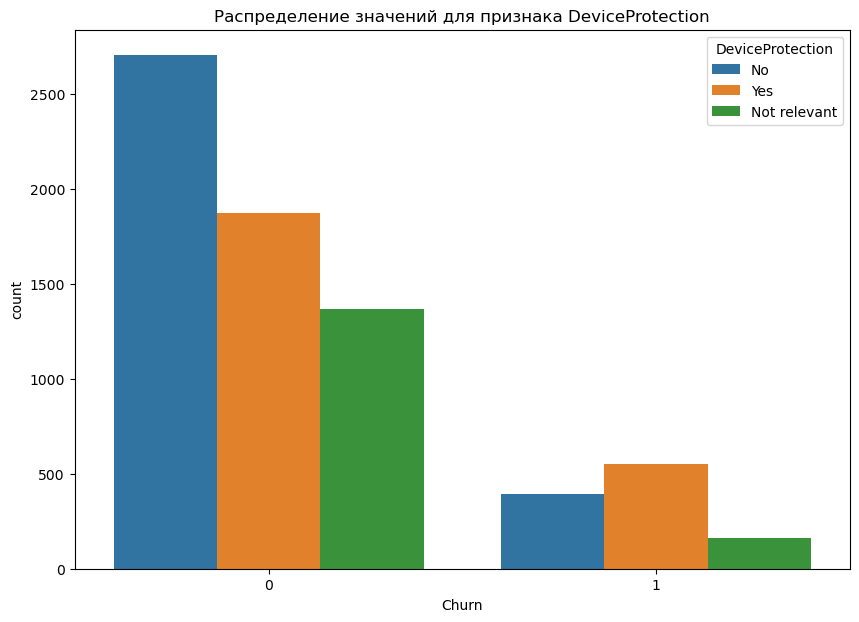

Признак TechSupport


,0,1
No,2930,543
Yes,1646,398
Not relevant,1366,160


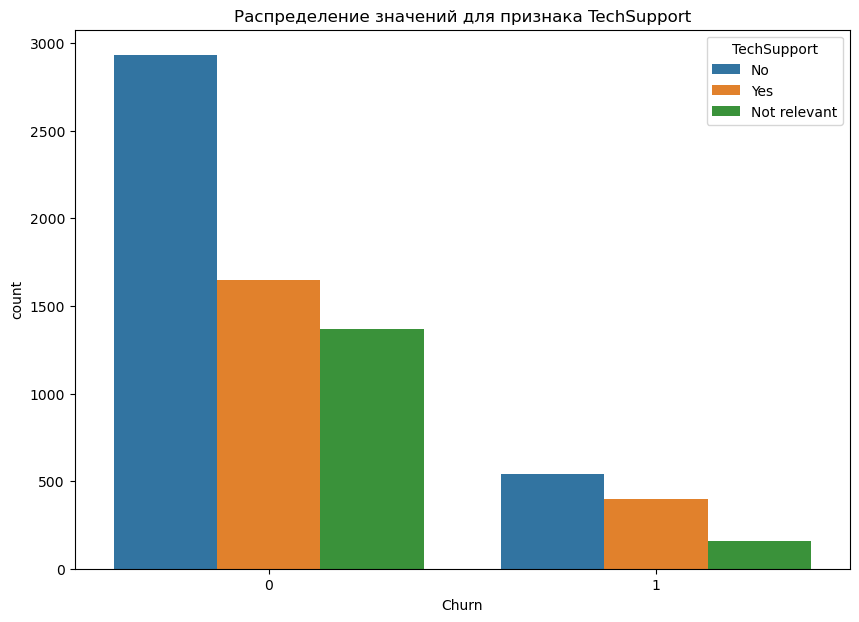

Признак StreamingTV


,0,1
No,2453,357
Yes,2123,584
Not relevant,1366,160


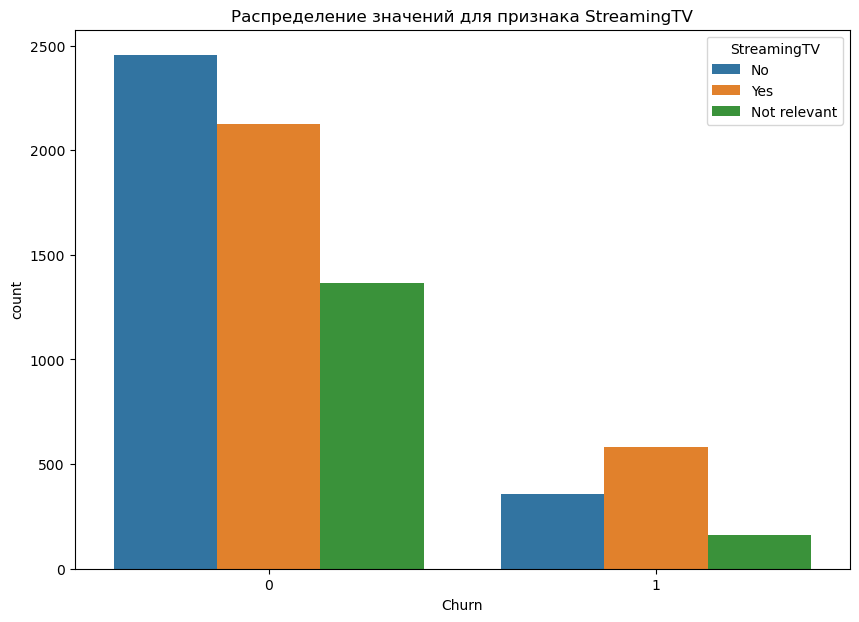

Признак StreamingMovies


,0,1
No,2450,335
Yes,2126,606
Not relevant,1366,160


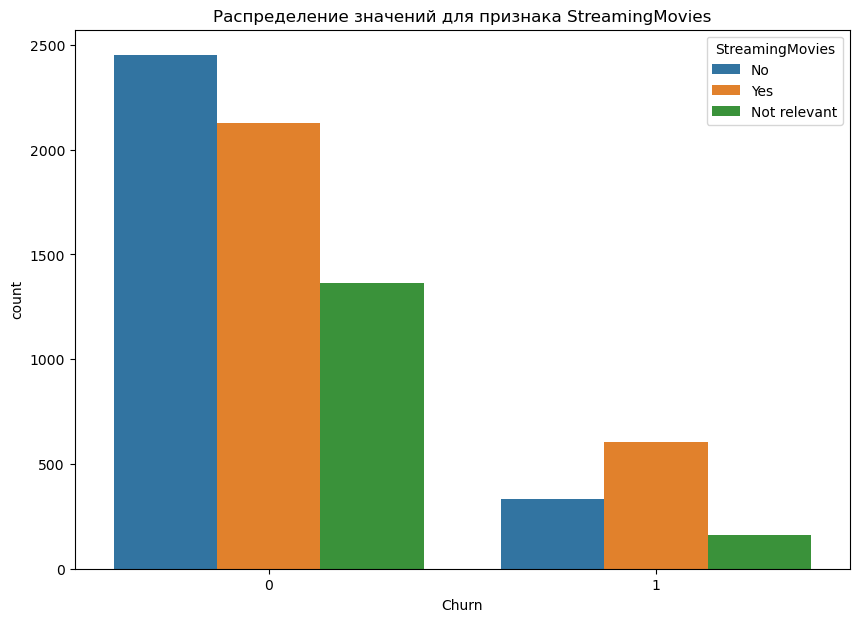

Признак Phone


,0,1
Yes,5363,998
No,579,103


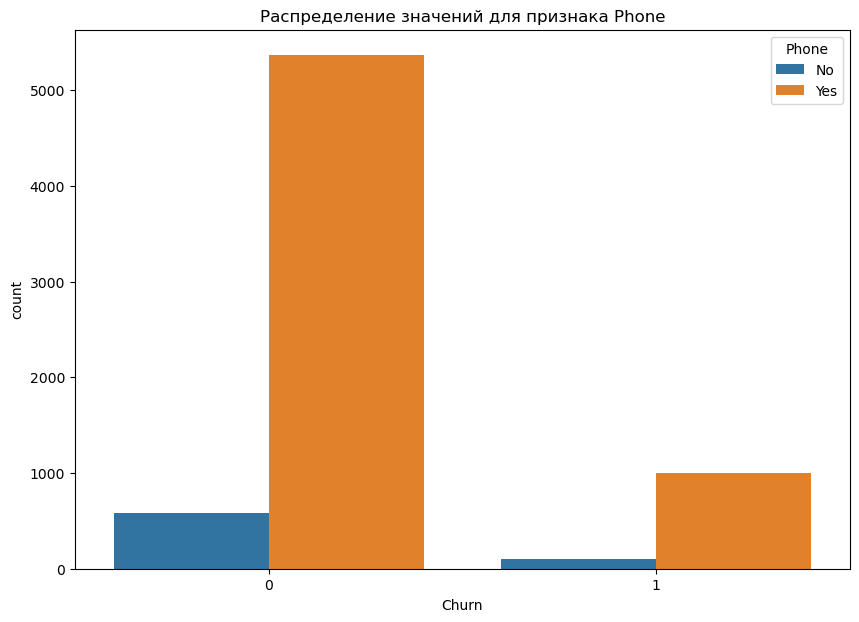

Признак MultipleLines


,0,1
No,3070,320
Yes,2293,678
Not relevant,579,103


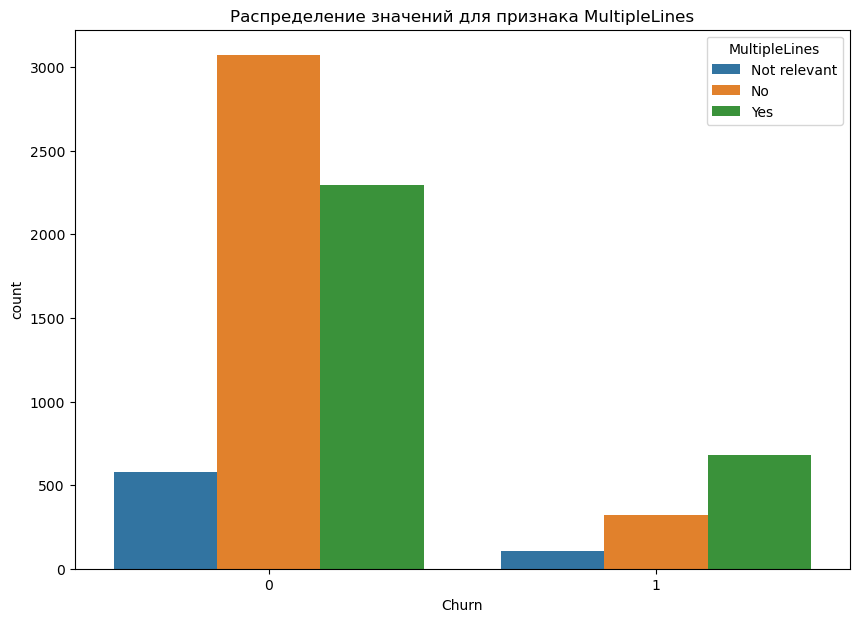

In [57]:
for feature in cat_features:
    print(f"Признак {feature}")
    display(value_count_groupedby(data, 'Churn', feature))
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.countplot(data=data, x = 'Churn', hue = data[feature])
    plt.title(f"Распределение значений для признака {feature}")
    plt.show()

На основании привеленных таблиц и графиков сложно сделать вывод о наличии явной взаимосвязи между конкретными категориальными признаками и целевым признаком. Например, можно заметить следующее:
1) Среди клиентов, не покинувших компанию, предпочтительным является помесячный тип оплаты.
2) Среди клиентов, не покинувших компанию, предпочтительным является оплата по электронному или почтовому счету. Среди клиентов, покинувших компанию, эти методы оплаты менее популярны.
3) Среди ушедших из компании клиентов больше доля состоящих в браке выше, чем среди оставшихся.
4) Среди клиентов, ушедших из компании несколько выше доля имеющих иждивенцев.
5) Клиенты, ушедшие из компании, чаще пользовались дополнительными услугами из пакетов: антивирусом и услугой блокировки небезопасных сайтов, услугой резервного копирования данных, выделенной линией техподдержки, стриминговым телевидением и каталогом фильмов, услугой подключения телефонного аппарата к нескольким линиям одновременно.

#### Матрица корреляции и отбор признаков

При помощи средств библиотеки `phik` создадим матрицу корреляции числовых и категориальных признааков и визуализируем ее средствами библиотеки `seaborn`.

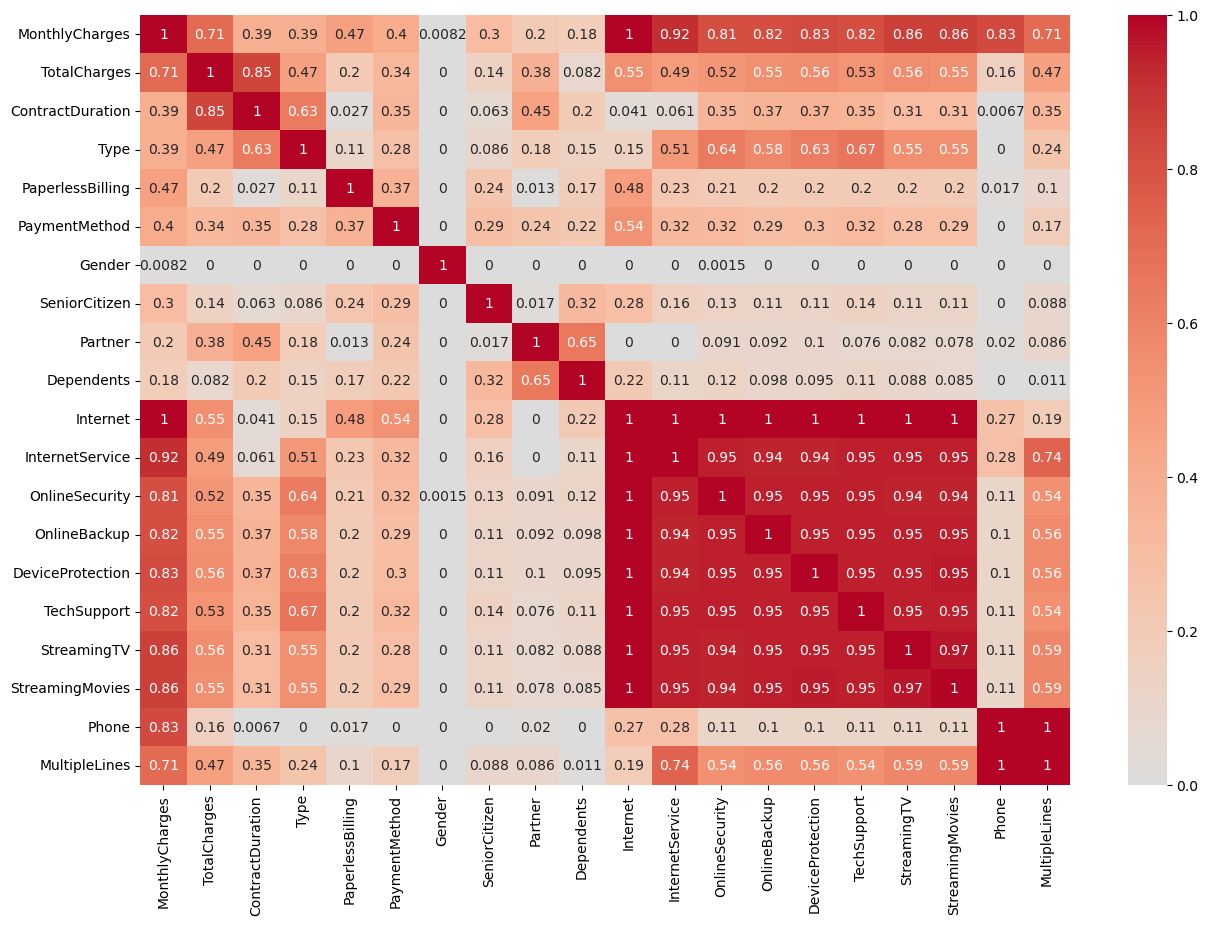

In [58]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(data[num_features+cat_features].phik_matrix(interval_cols=['MonthlyCharges',
                                                                       'TotalCharges',
                                                                        'ContractDuration']),
            cmap='coolwarm', center=0, annot=True);

Видим большое количество случаев сильной (более 0.8) корреляции между признаками. Добавленные данные о пользовании пакетами услуг ('Internet' и 'Phone') были полезны для анализа, но сильно коррелируют с признаками услуг, входящих в пакеты. Также можно видеть, что услуги пакета интернет-услуг сильно коррелируют между собой. Признак 'TotalCharges' коррелирует с 'ContractDuration'. Перепишем переменные num_features и cat_features без перечисленных признаков и попробуем снова создать тепловую карту.

In [59]:
num_features = ['MonthlyCharges',
                'ContractDuration']

cat_features = ['Type',
                'PaperlessBilling',
                'PaymentMethod',
                'Gender',
                'SeniorCitizen',
                'Partner',
                'Dependents',
                'MultipleLines']

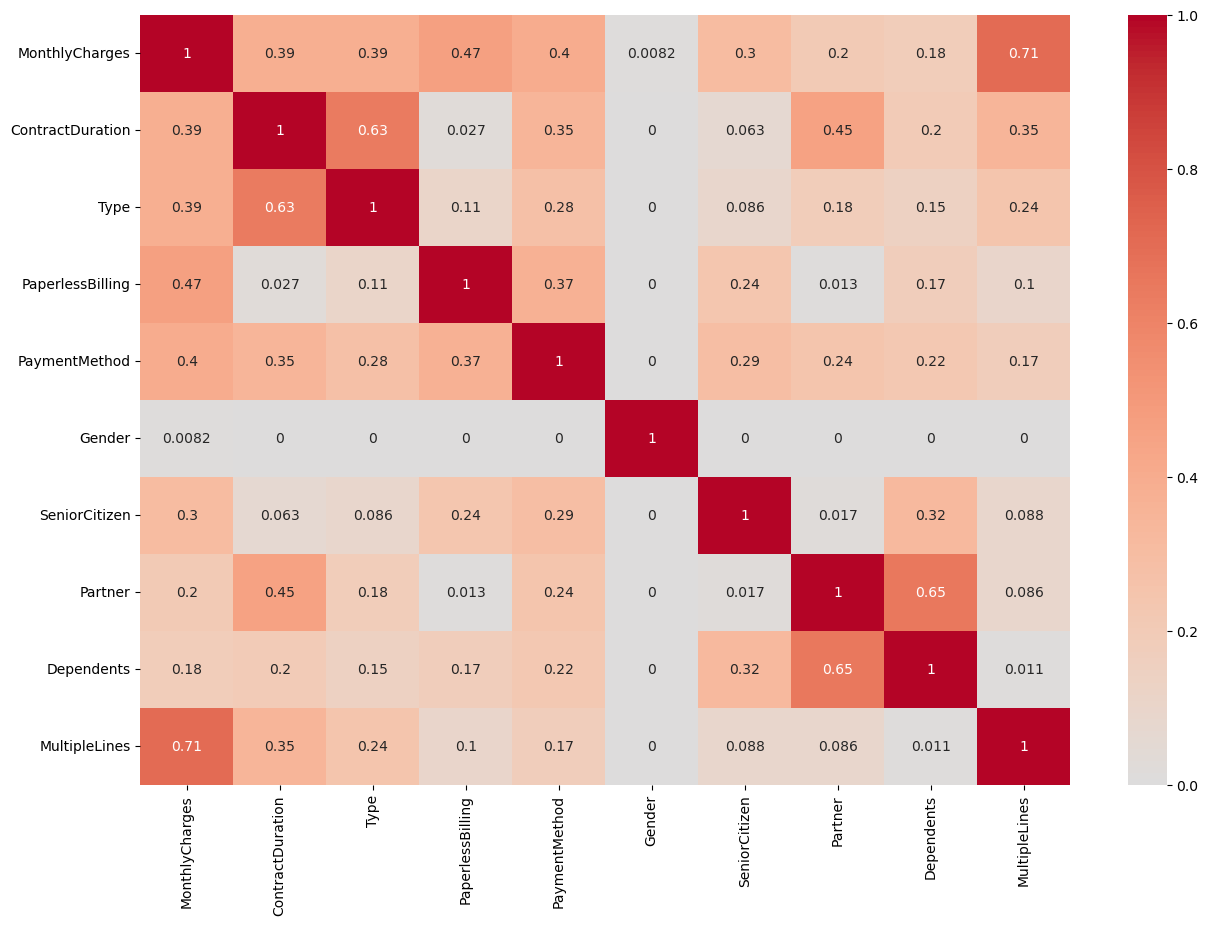

In [60]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(data[num_features+cat_features].phik_matrix(interval_cols=['MonthlyCharges',
                                                                       'ContractDuration']),
                                            annot=True, center=0, cmap= 'coolwarm');

Теперь между признаками нет сильной корреляции. Мультиколлинеарность устранена. Проверим, получится ли на данном наборе признаков обучить модель, которая бы показывала приемлемые показатели метрики.

**Выводы:**
1. Проанализировано распределение значений целевого признака. Обнаружен дисбаланс классов.
2. Рассмотрено распределение количественных признаков. Выявлено, что большинство клиенты предпочитают дешевые тарифы, при этом также обнаруживается большое количество клиентов с относительно высокой ежемесячной платой за услуги.
3. Рассмотрено распределение категориальных признаков. Выявлен ряд тенденций, позволяющий составить "портрет" типичного пользователя услуг компании. Это человек трудоспособного возраста, чаще всего не имеющий иждивенцев, пользующийся обоими пакетами услуг, но неохотно подключающий дополнительные услуги в рамках пакетов.
4. Анализ распределения количественных признаков в соотношении со значениями целевого признака показывает, что в первые месяцы после заключения договора, а также в случае пользования услугами компании в течение 5 лет и более клиенты редко уходят из компании. Также ушедшие клиенты чаще пользовались дорогими тарифами.
5. Анализ распределения категориальных признаков в соотношении со значениями целевого признака показывает, что среди ушедших клиентов более высока доля подключивших дополнительные услуги в рамках пакетов (возможно, этим и обясняется большое количество пользователей с высокой ежемесячной платой).
6. Построена матрица корреляции признаков. В целях борьбы с мультиколлинеарностью удалены признаки, показывающие сильную положительную корреляцию с другими признаками.

## Этап 2

На данном этапе подготовим данные к обучению,обучим модели и проверим качество наилучшей модели на тестовой выборке. По условиям задачи, должны быть выполнены следующие условия:
* Целевая метрика - AUC-ROC, значение целевой метрики лучшей модели должно быть не менее 0.85, но не более 0.95 (превышение данного порогового значение скорее всего связано с утечкой целевого признака).  
* RANDOM STATE - 70823.
* Соотношение обучающей и тестовой выборок – 3:1.
* Оценку качества модели необходимо проводить на кросс-валидации.
* При обучении следует использовать не менее двух разных алгоритмов (модели, основанные на деревьях решений/бустинги/логистическая регрессия).
* Качество лучшей модели необходимо проверить для тестовой выборке. Помимо основной метрики, на тестовой выборке также следует посчитать и интерпретировать значение Accuracy.
* Для результатов обучения на тестовой выборке необходимо осуществить анализ матрицы ошибок.
* Необходимо осуществить оценку важности признаков лучшей модели.

### Подготовка данных

#### Создание новых признаков

В данном разделе приведены результаты экспериментов по созданию новых признаков, которые при дальнейшем обучении моделей позволяют достичь требуемых показателей целевой метрики. При определении итогового набора признаков также будем бороться с коллинеарностью.

При анализе распределения признаков относительно целевого признака было отмечено, что что среди ушедших клиентов более высока доля подключивших дополнительные услуги в рамках пакетов. Может быть важно, использует ли клиент дополнительные услуги в рамках пакетов и в каком количестве.

Добавим в объединенную таблицу данные о количестве используемых дополнительных услуг, для чего сложим все положительные значения в столбцах с соответствующими значениями для каждого пользователя. Напомним, что все пользователи подключены по крайней мере к одному пакету, то есть могут использовать по крайней мере одну дополнительную услугу.

In [61]:
data['ExtraOptionNumber'] = (data['OnlineSecurity'] == "Yes").astype('int') + (
    data['OnlineBackup'] == "Yes").astype('int') + (data['OnlineBackup'] == "Yes").astype('int') + (
    data['DeviceProtection'] == "Yes").astype('int') + (data['TechSupport'] == "Yes").astype('int') + (
    data['StreamingTV'] == "Yes").astype('int') + (data['StreamingMovies'] == "Yes").astype('int') + (
    data['MultipleLines'] == "Yes").astype('int')

Выведем количество значений в столбце 'ExtraOptionNumber'.

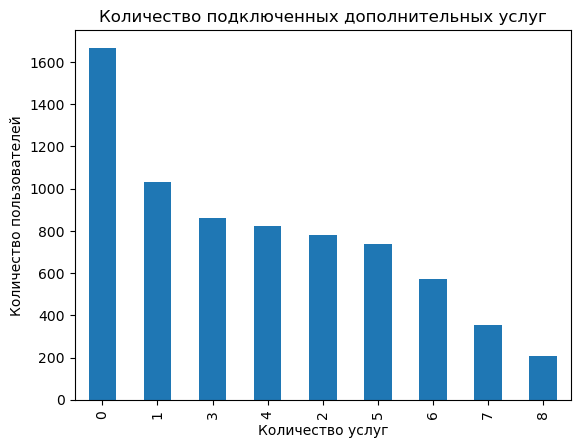

In [62]:
data['ExtraOptionNumber'].value_counts().plot(kind='bar',
                                              xlabel="Количество услуг",
                                              ylabel="Количество пользователей",
                                              title="Количество подключенных дополнительных услуг");

Можно видеть, что наиболее многочисленна группа пользователей, не подключивших дополнительные услуги, вторая по численности группа - подключившие одну услугу, примерно одинаковы по численности группы клиентов, подключивших от 2 до 6 услуг, наименее многочисленны группы подключивших более 6 услуг.

Создадим категориальный признак 'ExtraOptionCategory' для перечисленных выше групп. Для этого напишем функцию, возвращающую категорию по условию, затем применим эту функцию к столбцу 'ExtraOptionNumber'.

In [63]:
def extra_service_category(data):
    if data == 0:
        return 'Not any'
    if data == 1:
        return 'One'
    if 2 <= data <= 6:
        return 'Some'
    if data >= 7:
        return 'Many'

In [64]:
data['ExtraOptionCategory'] = data['ExtraOptionNumber'].apply(extra_service_category)

Перепишем переменные num_features и cat_features и еще раз построим матрицу корреляции.

In [65]:
num_features = ['MonthlyCharges',
                'ContractDuration',
                'ExtraOptionNumber']

cat_features = ['Type',
                'PaperlessBilling',
                'PaymentMethod',
                'Gender',
                'SeniorCitizen',
                'Partner',
                'Dependents',
                'MultipleLines',
                'ExtraOptionCategory']

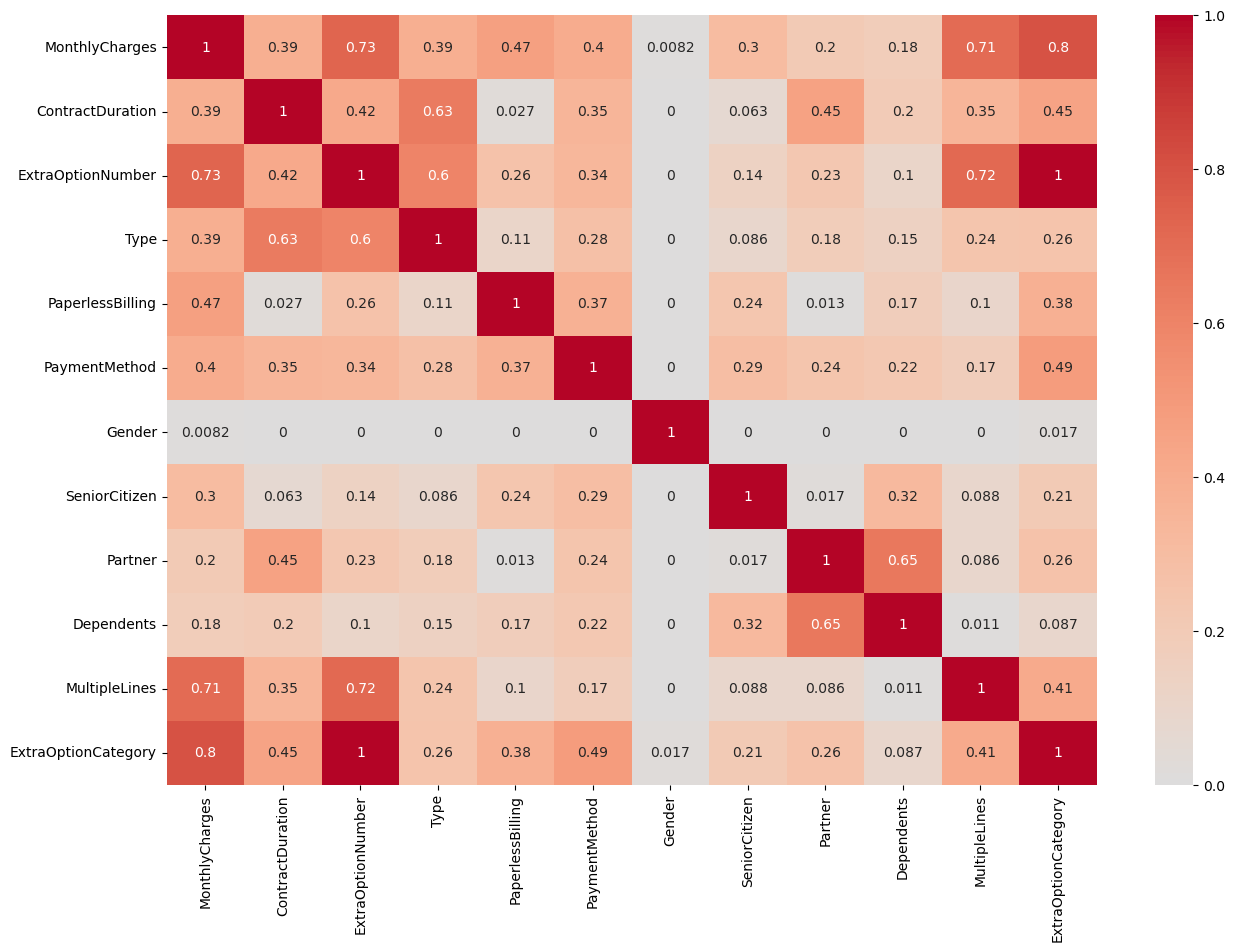

In [66]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(data[num_features+cat_features].phik_matrix(interval_cols=['MonthlyCharges',
                                                                       'ContractDuration',
                                                                       'ExtraOptionNumber']
                                                       ),
                                            annot=True, center=0, cmap= 'coolwarm');

Удалим коррелирующие значения и проверим результат.

In [67]:
num_features = ['ContractDuration']

cat_features = ['Type',
                'PaperlessBilling',
                'PaymentMethod',
                'Gender',
                'SeniorCitizen',
                'Partner',
                'Dependents',
                'MultipleLines',
                'ExtraOptionCategory']

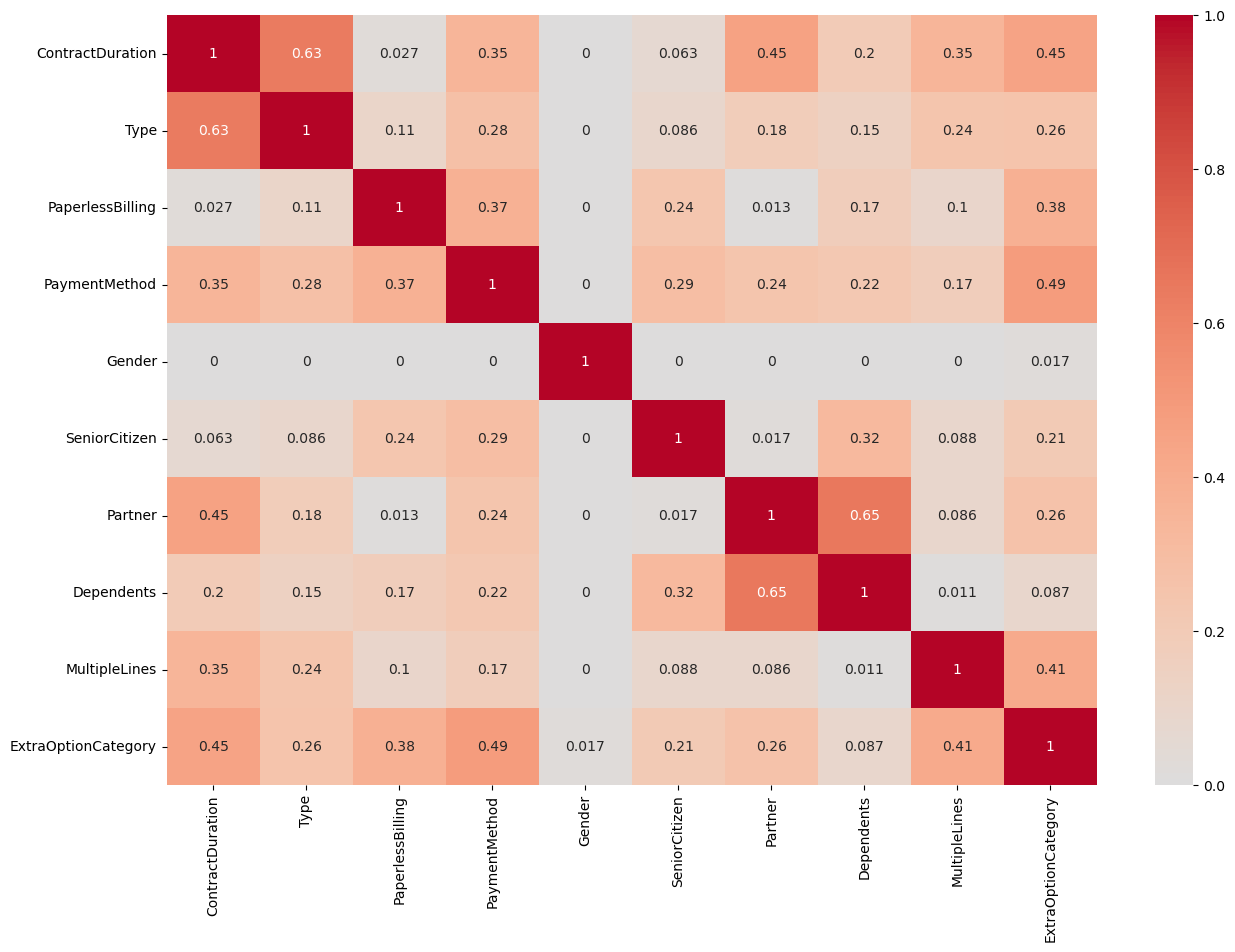

In [68]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(data[num_features+cat_features].phik_matrix(interval_cols=['ContractDuration']),
            annot=True, center=0, cmap= 'coolwarm');

Обучим модели на полученном наборе признаков.

#### Разделение на выборки

Выделим из таблицы `data` признаки и целевой признак. Набор признаков задаем в соответствии с последними версиями списков числовых и категориальных признаков, целевой признак - значения столбца `Churn`.

In [69]:
target = data['Churn']
features = data[num_features+cat_features]

Разделим данные на обучающую и тестовую выборки в соотношении 3:1.

In [70]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE, stratify=target)

Проверим, что разделили данные в требуемом соотношении.

In [71]:
display(features_train.shape)
display(target_train.shape)
display(features_test.shape)
target_test.shape

(5282, 10)

(5282,)

(1761, 10)

(1761,)

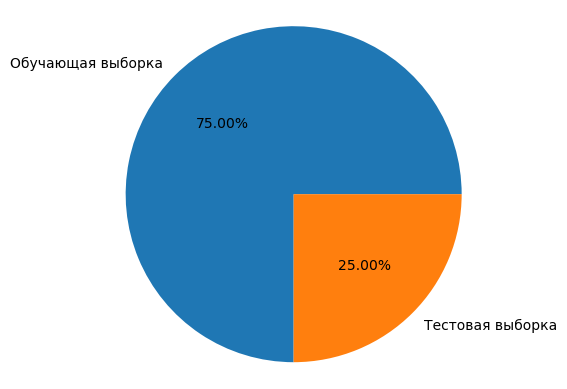

In [72]:
fig, ax = plt.subplots()
ax.pie([target_train.shape[0], target_test.shape[0]], labels=['Обучающая выборка', 'Тестовая выборка'],
      autopct='%1.2f%%')
ax.axis("equal")
plt.show()

#### Кодирование признаков

Выведем информацию о выбранном наборе признаков при момощи функции `data_overview()`

In [73]:
data_overview(features_train)

,ContractDuration,Type,PaperlessBilling,PaymentMethod,Gender,SeniorCitizen,Partner,Dependents,MultipleLines,ExtraOptionCategory
2857,1432,Two year,No,Bank transfer (automatic),Female,0,Yes,Yes,No,Some
4676,580,Month-to-month,Yes,Electronic check,Male,0,No,Yes,No,Not any
2291,245,Month-to-month,Yes,Electronic check,Female,0,No,No,Yes,Some
3784,1187,Month-to-month,Yes,Electronic check,Male,1,No,No,Yes,Some
698,1432,One year,Yes,Bank transfer (automatic),Male,1,Yes,Yes,No,Some


(5282, 10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 2857 to 5047
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ContractDuration     5282 non-null   int64 
 1   Type                 5282 non-null   object
 2   PaperlessBilling     5282 non-null   object
 3   PaymentMethod        5282 non-null   object
 4   Gender               5282 non-null   object
 5   SeniorCitizen        5282 non-null   object
 6   Partner              5282 non-null   object
 7   Dependents           5282 non-null   object
 8   MultipleLines        5282 non-null   object
 9   ExtraOptionCategory  5282 non-null   object
dtypes: int64(1), object(9)
memory usage: 453.9+ KB


None

,ContractDuration
count,5282.000000
mean,897.182507
std,684.872599
min,0.000000
25%,276.000000
50%,761.000000
75%,1453.750000
max,2314.000000


Количество дубликатов: 764


Убедились, что все категориальные признаки имеют тип `object`

Для деревьев и бустингов подходит порядковое кодирование категориальных признаков.

In [74]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=1000)

In [75]:
oe_features_train = features_train.copy()
oe_features_test = features_test.copy()
oe_features_train[cat_features] = encoder.fit_transform(features_train[cat_features])
oe_features_test[cat_features] = encoder.transform(features_test[cat_features])

Проверим результат кодирования: выведем на экран первые 5 строк таблицы `oe_features_train`.

In [76]:
oe_features_train.head()

,ContractDuration,Type,PaperlessBilling,PaymentMethod,Gender,SeniorCitizen,Partner,Dependents,MultipleLines,ExtraOptionCategory
2857,1432,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0
4676,580,0.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0
2291,245,0.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,3.0
3784,1187,0.0,1.0,2.0,1.0,1.0,0.0,0.0,2.0,3.0
698,1432,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,3.0


Для линейных моделей используем прямое кодирование категориальных признаков. Напишем функцию, которая принимает на вход датасет, содержащий признаки, и возвращает датасет с закодированными категориальными признаками (в функции запишем только метод `transform`).

In [77]:
def get_ohe(data):
    temp_data = pd.DataFrame(data=encoder_ohe.transform(data[cat_features]),
                             columns=encoder_ohe.get_feature_names_out())
    data.drop(columns=cat_features, axis=1, inplace=True)
    data = pd.concat([data.reset_index(drop=True), temp_data], axis=1)
    return data

Закодируем признаки при помощи `OneHotEncoder`. Применим метод `fit()` к обучающему набору признаков, после чего к обучающей и тестовой выборке применим функцию `get_ohe()`

In [78]:
encoder_ohe = OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first')
encoder_ohe.fit(features_train[cat_features])

ohe_features_train = get_ohe(features_train.copy())
ohe_features_test = get_ohe(features_test.copy())

Проверим результат кодирования: выведем на экран первые 5 строк таблицы `ohe_features_train`.

In [79]:
ohe_features_train.head()

,ContractDuration,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,MultipleLines_Not relevant,MultipleLines_Yes,ExtraOptionCategory_Not any,ExtraOptionCategory_One,ExtraOptionCategory_Some
0,1432,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,580,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,245,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1187,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1432,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


Масштабируем количественные признаки признаки (в нашем наборе признаков он получился всего один, но могло быть больше). Применим его ко всем наборам признаков (исходный, oe и ohe).

In [80]:
def scale_data(data_train, data_test):
    scaler = StandardScaler()
    data_train[num_features] = scaler.fit_transform(data_train[num_features])
    data_test[num_features] = scaler.transform(data_test[num_features])
    return data_train, data_test

In [81]:
oe_features_train, oe_features_test = scale_data(oe_features_train, oe_features_test)
ohe_features_train, ohe_features_test = scale_data(ohe_features_train, ohe_features_test)
features_train, features_test = scale_data(features_train, features_test)

Также поменяем в исходном наборе признаков тип данных категориальных признаков c `object` на `category`. Это позволит модели `LGBMClassifier` работать с незакодированными признаками.

In [82]:
features_train[cat_features] = features_train[cat_features]. astype('category')
features_test[cat_features] = features_test[cat_features]. astype('category')

Признаки закодированы, можно приступать к обучению.

### Обучение моделей

Для обобщающей таблицы создадим пустые списки, в которые будем добавлять необходимые значения по ходу обучения моделей.

In [83]:
best_model = []
best_params = []
best_roc_auc = []

In [84]:
def cv_estimator(model, params, features_train, target_train):
    model = model
    params = params
    grid = GridSearchCV(model, params, scoring='roc_auc', cv=5, n_jobs=-1)
    grid.fit(features_train, target_train)
    best_model.append(grid.best_estimator_)
    best_params.append(grid.best_params_)
    best_roc_auc.append(grid.best_score_)
    print(f'Гиперпараметры лучшей модели: {grid.best_params_}')
    print(f'AUC-ROC лучшей модели: {grid.best_score_}')
    return grid  

Обучим модели с применением взвешивания классов. Целевая метрика AUC-ROC нечувствительна к дисбалансу, однако метрика Accuracy, которую мы дополнительно будем считать для лучшей модели на тестовой выборке, чувствительна. К тому же, использование балансировки классов при обучении, дает, на мой взгляд, более приемлемый результат с точки зрения предсказания положительного класса - ухода клиента (это касается всех моделей, для лучшей модели соответствующее обоснование приведено в разделе "Тестирование лучшей модели").

#### DesicionTreeClassifier

In [85]:
grid_dt = cv_estimator(DecisionTreeClassifier(random_state=RANDOM_STATE, 
                                              class_weight='balanced'),
                      {'max_depth': range(1, 6), 'min_samples_leaf': range(1, 6)},
                      oe_features_train, target_train)

Гиперпараметры лучшей модели: {'max_depth': 5, 'min_samples_leaf': 1}
AUC-ROC лучшей модели: 0.80427616045336


#### RandomForestClassifier

In [86]:
grid_rf = cv_estimator(RandomForestClassifier(random_state=RANDOM_STATE,
                                             class_weight='balanced'),
                      {'max_depth': [None] + [i for i in range(1, 7)],
                       'min_samples_leaf': range(1, 6),
                       'n_estimators': [100, 200, 300]},
                       oe_features_train, target_train)

Гиперпараметры лучшей модели: {'max_depth': 6, 'min_samples_leaf': 5, 'n_estimators': 300}
AUC-ROC лучшей модели: 0.8275281867055974


#### CatBoostClassifier

Модель `CatBoostClassifier` может работать с незакодированными категориальными признаками, для этого в параметр `cat_features` следует передать имена категориальных признаков (`cat_features=cat_features`), а в метод `fit` передается набор признаков, в котором категориальные признаки не закодированы (в нашем случае это `features_train`). Данный способ обработки категориальных признаков на модели `CatBoostClassifier` был использован в ходе экспериментов по подбору признаков и параметров, дающих наилучшее значение итоговой метрики, однако при данном способе кодирования результаты получаются несколько хуже, чем при использовании набора данных, в котором категориальные признаки закодированы техникой порядкового кодирования, поэтому будем использовать набор данных, в котором категориальные признаки закодированы техникой порядкового кодирования.

In [87]:
grid_cb = cv_estimator(CatBoostClassifier(random_state=RANDOM_STATE, verbose=False,
                                         auto_class_weights='Balanced'),
                      {'depth':  range(1, 7),
                       'learning_rate':[.1, .3, .5],
                       'iterations': [100, 200, 300]},
                        oe_features_train, target_train)

Гиперпараметры лучшей модели: {'depth': 2, 'iterations': 300, 'learning_rate': 0.5}
AUC-ROC лучшей модели: 0.9368624366404589


#### LGBMClassifier

In [88]:
grid_gbm = cv_estimator(LGBMClassifier(random_state=RANDOM_STATE,
                                      class_weight='balanced'),
                      {'max_depth': [None] + [i for i in range(1, 7)],
                       'learning_rate':[.1, .3, .5],
                       'n_estimators': [100, 200, 300]},
                       features_train, target_train)

Гиперпараметры лучшей модели: {'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 300}
AUC-ROC лучшей модели: 0.917242715023658


#### LogisticRegression

Для обучения логистической регрессии используем набор данных, в котором категориальные признаки закодированы с применением техники прямого кодирования.

In [89]:
grid_lr = cv_estimator(LogisticRegression(random_state=RANDOM_STATE,
                                         class_weight='balanced'),
                      {'C': [0.01, 0.1, 1, 10],
                       'penalty': ['l1', 'l2'],
                       'solver': ['liblinear']},
                      ohe_features_train, target_train)

Гиперпараметры лучшей модели: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
AUC-ROC лучшей модели: 0.7561402981518175


Обобщим результаты в таблице `models_compared`.

In [90]:
models_compared = (pd.DataFrame
                   (
    {
        'модель':['DecisionTreeClassifier',
                  'RandomForestClassifier',
                  'CatBoostClassifier',
                  'LGBMClassifier',
                  'LogisticRegression'],
        'гиперпараметры лучшей модели': best_params,
        'AUC_ROC': best_roc_auc
    }
                   )
                   .set_index(['модель'])
                   .style
                   .background_gradient(cmap='Blues', axis=0)
                   .set_caption("Лучшие результаты AUC-ROC на кросс-валидации")
                   .set_properties(subset=['AUC_ROC'], **{'width': '300px'})
                   .set_table_styles(
                       [
                           {
                               'selector': 'caption',
                               'props': 
                               [('color', 'black'),
                                ('font-size', '18px')]
                           }
                       ]
                   )
                  )

models_compared

,гиперпараметры лучшей модели,AUC_ROC
модель,,
DecisionTreeClassifier,"{'max_depth': 5, 'min_samples_leaf': 1}",0.804276
RandomForestClassifier,"{'max_depth': 6, 'min_samples_leaf': 5, 'n_estimators': 300}",0.827528
CatBoostClassifier,"{'depth': 2, 'iterations': 300, 'learning_rate': 0.5}",0.936862
LGBMClassifier,"{'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 300}",0.917243
LogisticRegression,"{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}",0.756140


Лучший результат на кросс-валидации показала модель `LGBMClassifier` c гиперпараметрами `{'depth': 2, 'iterations': 300, 'learning_rate': 0.5}`

Сохраним лучшую модель. Выберем ее с помощью цикла из значений списка `best_model`.

In [91]:
best_result = 0
for i in range(len(best_roc_auc)):
    if best_roc_auc[i] > best_result:
        best_result = best_roc_auc[i]
        model_best = best_model[i]

### Тестирование лучшей модели

#### Метрика ROC-AUC

Определим значение ROC-AUC для лучшей модели на тестовой выборке. При `refit=True` модель обучается на лучших параметрах на всей обучающей выборке. Таким образом, модель уже обучена. С одинаковым результатом можно применить метод `.predict()` к гриду и его атрибуту `.best_estimator_` (вызов атрибута у грида автоматически вызывает его у атрибута `.best_estimator_`).

In [92]:
probabilities_test = model_best.predict_proba(oe_features_test)
probabilities_one_test = probabilities_test[:, 1]
roc_auc_test = roc_auc_score(target_test, probabilities_one_test)
print("Значение ROC_AUC наилучшей модели на тестовой выборке:", roc_auc_test)

Значение ROC_AUC наилучшей модели на тестовой выборке: 0.9324067050042825


Визуализируем показатель AUC-ROC на графике, изображающем ROC-кривую, в сопоставлении с данными случайной модели. На графике видно, что значение AUC_ROC выбранной наилучшей модели существенно отличается от значения для случайной модели (последнее всегда равно 0.5)

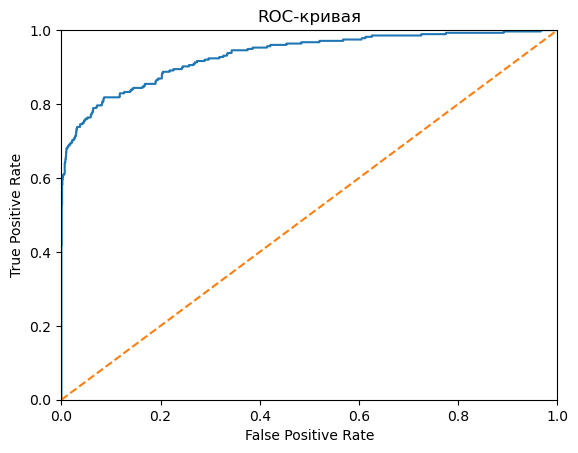

In [93]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

Проверим также результат работы константной модели.

In [94]:
model_dummy = DummyClassifier(random_state=RANDOM_STATE)
model_dummy.fit(oe_features_train, target_train)
probabilities_dummy = model_dummy.predict_proba(features_test)
probabilities_one_dummy= probabilities_dummy[:, 1]
roc_auc_dummy = roc_auc_score(target_test, probabilities_one_dummy)
print("Значение AUC-ROC константной модели на тестовой выборке:", roc_auc_dummy)

Значение AUC-ROC константной модели на тестовой выборке: 0.5


Действительно, значение ROC_AUC константной модели на тестовой выборке равно 0.5. Результат для лучшей модели (0.93) значительно выше случайного результата. 

#### Метрика Accuracy

По условию задачи необходимо также посчитать метрику Accuracy для лучшей модели на тестовой выборке.

In [95]:
predictions_test = model_best.predict(oe_features_test)
accuracy_test = accuracy_score(target_test, predictions_test)
print("Значение accuracy наилучшей модели на тестовой выборке:", accuracy_test)

Значение accuracy наилучшей модели на тестовой выборке: 0.8932424758659853


Метрика `Accuracy` показывает, что на тестовой выборке предсказания модели (уйдет или не уйдет клиент) верны в 89,32% случаев, соответственно, ошибки составляют 10,68% предсказаний. При этом ничего неизвестно о том, какую долю всех ошибок составляют ложноположительные (модель неверно предсказала, что клиент уйдет) и ложноотрицательные (модель неверно предсказала, что клиент не уйдет) результаты. Их соотношение рассмотрим ниже, при анализе матрицы ошибок.

Сравнение с `Accuracy` константной модели.

In [96]:
predictions_dummy = model_dummy.predict(oe_features_test)
accuracy_dummy = accuracy_score(target_test, predictions_dummy)
print("Значение accuracy константной модели на тестовой выборке:", accuracy_dummy)

Значение accuracy константной модели на тестовой выборке: 0.8438387279954571


Значение `Accuracy` на тестовой выборке оказывается выше (хотя и ненамного) значения данной метрики для константной модели. Можно говорить об адекватности модели.

Представим значения метрик лучшей модели, подобранной на кросс-валидации, и константной модели в виде таблицы 

In [97]:
best_vs_dummy = (pd.DataFrame
                   (
    {
        'метрика':['AUC_ROC',
                  'Accuracy'],
        'CatBoostClassifier': [roc_auc_test, accuracy_test],
        'DummyClassifier': [roc_auc_dummy, accuracy_dummy]
    }
                   )
                   .set_index(['метрика'])
                   .style
                   .format('{:.4f}')
                   .set_caption("Метрики лучшей и константной моделей на тестовой выборке")
                   .set_properties(subset=['CatBoostClassifier'], **{'width': '250px'})
                   .set_properties(subset=['DummyClassifier'], **{'width': '250px'})
                   .set_table_styles(
                       [
                           {
                               'selector': 'caption',
                               'props': 
                               [('color', 'black'),
                                ('font-size', '18px')]
                           }
                       ]
                   )
                  )

            
                  
best_vs_dummy

,CatBoostClassifier,DummyClassifier
метрика,,
AUC_ROC,0.9324,0.5000
Accuracy,0.8932,0.8438


#### Матрица ошибок

Построим матрицу ошибок и визуализируем ее средствами библиотеки `seaborn`

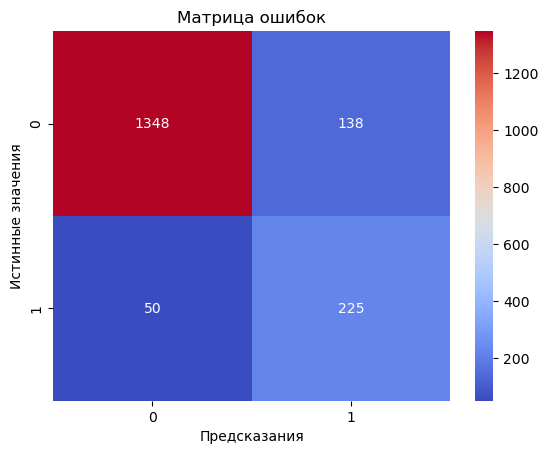

In [98]:
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(target_test, predictions_test),
            cmap='coolwarm', fmt='d', annot=True)
plt.title('Матрица ошибок')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказания')
plt.show()

Также выведем на экран данные об общем количестве объектов в тестовой выборке и о количестве значений каждого класса в целевом признаке.

In [99]:
print(f'Всего {target_test.shape[0]}')
target_test.value_counts()

Всего 1761


0    1486
1     275
Name: Churn, dtype: int64

Для наглядности матрицу ошибок также можно вывести в долях от общего объема тестовой выборки

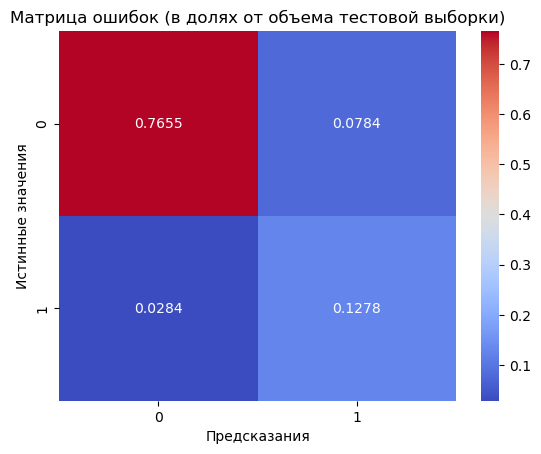

In [100]:
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(target_test, predictions_test) / 
            confusion_matrix(target_test, predictions_test).sum(),
            cmap='coolwarm', fmt=".4f", annot=True)
plt.title('Матрица ошибок (в долях от объема тестовой выборки)')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказания')
plt.show()

Матрица показывает количество значений обоих классов целевого признака, которые лучшая модель предсказала правильно или неправильно на тестовой выборке.  Всего тестовая выборка содержит данные о 1761 клиенте, 275 из которых ушли из компании. По главной диагонали матрицы расположены правильные ответы, в сумме составляющие 89.32% от всей выборки (это и есть значение accuracy). При этом модель правильно предсказала уход 225 клиентов и не предсказала уход 50 клиентов (18.18% от всех ушедших клиентов). В 138 случаях модель предсказала уход клиентов, которые на самом деле остались. При прогнозировании ухода клиентов из компании такие ложноположительные результаты приведут к тому, что промокоды и специальные условия будут предложены клиентам, которые и так остались бы в компании.

#### Значение дополнительных метрик при отсутствии борьбы с дисбалансом

Целевая метрика AUC-ROC нечувствительна к дисбалансу, однако метрика Accuracy и результаты матрицы ошибок при отсутствии балансировки будут отличаться от приведенных выше результатов. Посмотрим, какие результаты на тестовой выборке покажет лучшая модель, обученная без учета дисбаланса.

In [101]:
model_cb_unbalanced = CatBoostClassifier(random_state=RANDOM_STATE, verbose=False, 
                                         depth=2, 
                                         learning_rate=.5,
                                         iterations=300)
model_cb_unbalanced.fit(oe_features_train, target_train)
probabilities_test_unbalanced = model_cb_unbalanced.predict_proba(oe_features_test)
probabilities_one_test_unbalanced = probabilities_test[:, 1]
roc_auc_test_unbalanced = roc_auc_score(target_test, probabilities_one_test_unbalanced)
print("Значение ROC_AUC наилучшей модели без взвешивания классов на тестовой выборке:", 
      roc_auc_test_unbalanced)

Значение ROC_AUC наилучшей модели без взвешивания классов на тестовой выборке: 0.9324067050042825


Убедились, что метрика AUC-ROC нечувствительна к дисбалансу и дает то же значение, что приведено выше для лучшей модели с балансировкой классов.

Обратимся к метрике Accuracy.

In [102]:
predictions_test_unbalanced = model_cb_unbalanced.predict(oe_features_test)
accuracy_test_unbalanced = accuracy_score(target_test, predictions_test_unbalanced)
print("Значение accuracy наилучшей модели без взвешивания классов на тестовой выборке:", 
      accuracy_test_unbalanced)

Значение accuracy наилучшей модели без взвешивания классов на тестовой выборке: 0.9432140829074389


Значение Accuracy на тестовой выборке выше, чем для модели, обученной с учетом дисбаланса: модель дает верные предсказания в 94,32%. На первый взгляд, этот результат лучше, чем для аналогичной модели с балансировкой. Посмотрим на результаты матрицы ошибок. 

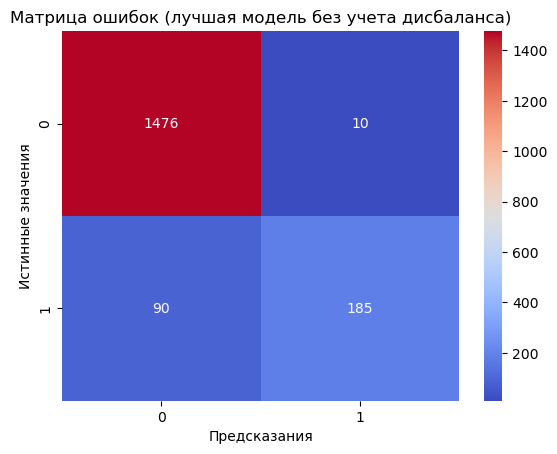

In [103]:
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(target_test, predictions_test_unbalanced),
            cmap='coolwarm', fmt='d', annot=True)
plt.title('Матрица ошибок (лучшая модель без учета дисбаланса)')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказания')
plt.show()

Представим данную матрицу также в долях от общего объема тестовой выборки.

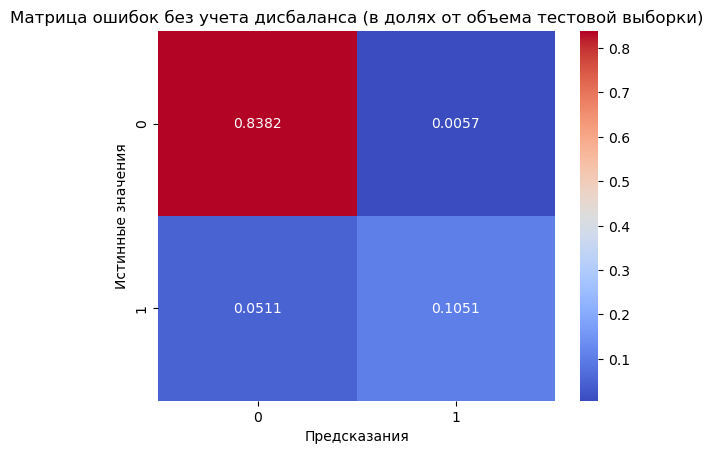

In [104]:
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(target_test, predictions_test_unbalanced) / 
            confusion_matrix(target_test, predictions_test_unbalanced).sum(),
            cmap='coolwarm', fmt=".4f", annot=True)
plt.title('Матрица ошибок без учета дисбаланса (в долях от объема тестовой выборки)')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказания')
plt.show()

Несмотря на то, что значение Accuracy модели, обученной без учета дисбаланса, выше, положительный класс она предсказывает хуже: модель показывает ложноотрицательный результат в 90 случаях из 275 (32,73% от всех ушедших клиентов), при этом ложноположительных случаев всего 10 - промокоды и специальные условия будут гораздо реже предлагаться клиентам, которые и так останутся в компании. При прочих равных результаты модели с учетом дисбаланса классов, по моему мнению, более адекватны поставленной заказчиком задаче (предсказать уход клиентов), однако считаю необходимым ознакомить заказчика с обоими вариантами, чтобы дать возможность оценить возможную упущенную выгоду от ухода клиента и от предложения промокодов и специальных условий клиентам, которые на самом деле не собираются уйти из компании. 

### Оценка важности признаков

Рассмотрим два инструмента оценки значимости признаков модели: 1) атрибут `feature_importances_`, 2) средства библиотеки `shap`.

#### feature_importances_

Выведем на экран показатели значимости модели для лучшей модели (напомним, что она обучена на обучающей выборке).

In [105]:
model_best.feature_importances_

array([90.50161573,  2.36278016,  0.2556162 ,  1.3783303 ,  0.86383383,
        0.21929786,  1.00336359,  0.11315851,  1.32236173,  1.9796421 ])

Можно заметить, что все значения в сумме составляют 100. Для наглядности сначала выведем признаки и их значимости в порядке убывания.

In [106]:
pd.DataFrame(model_best.feature_importances_, index = num_features+cat_features,
             columns=['feature_importances']).sort_values(by='feature_importances',
                                                          ascending=False)


,feature_importances
ContractDuration,90.501616
Type,2.362780
ExtraOptionCategory,1.979642
PaymentMethod,1.378330
MultipleLines,1.322362
Partner,1.003364
Gender,0.863834
PaperlessBilling,0.255616
SeniorCitizen,0.219298
Dependents,0.113159


Наиболее важным для модели является признак `ContractDuration` со значимостью более 90%. На остальные признаки приходятся оставшиеся 9.5%: среди этих признаков выделяются `Type` и  `ExtraOptionCategory`. На четвертом месте признак `PaymentMethod`.

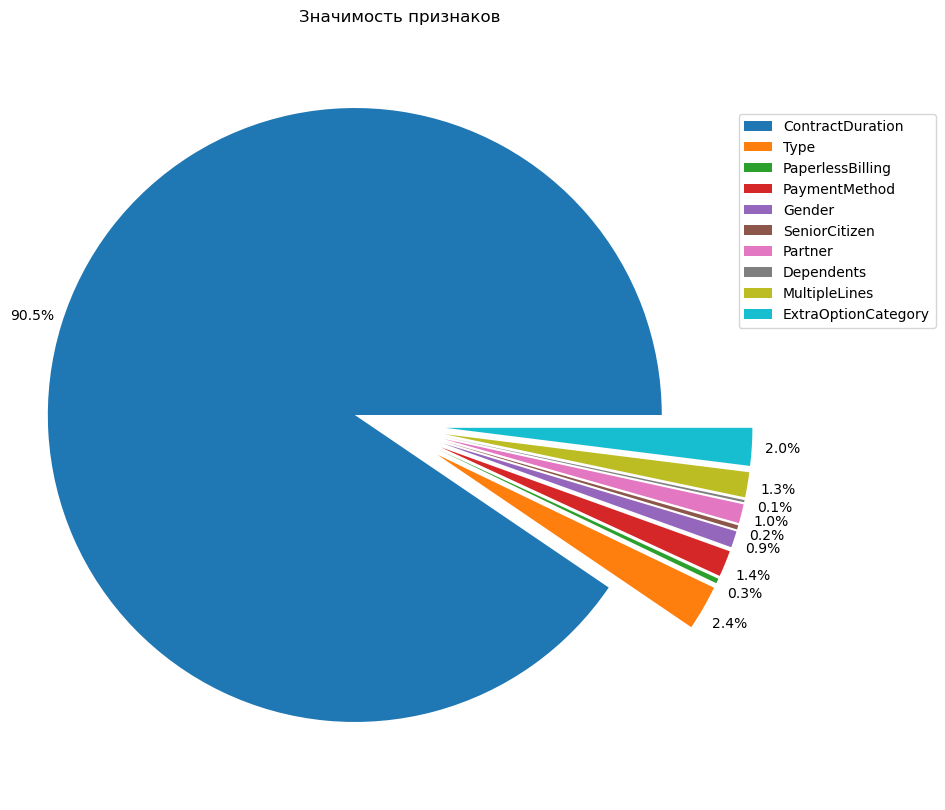

In [107]:
explode = [0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
fig, ax = plt.subplots(figsize=(10,10))
ax.pie(model_best.feature_importances_, explode=explode, autopct='%1.1f%%', pctdistance=1.1)
ax.axis("equal")
plt.legend(num_features+cat_features, loc=1, bbox_to_anchor=(1.2,0.9))
plt.title("Значимость признаков")
plt.show()

#### shap

Средства библиотеки `shap` являются более продвинутым инструментом для оценки значимости признаков модели. Рассмотрим значимость признаков для лучшей модели на обучающей выборке с использованием библиотеки `shap`.

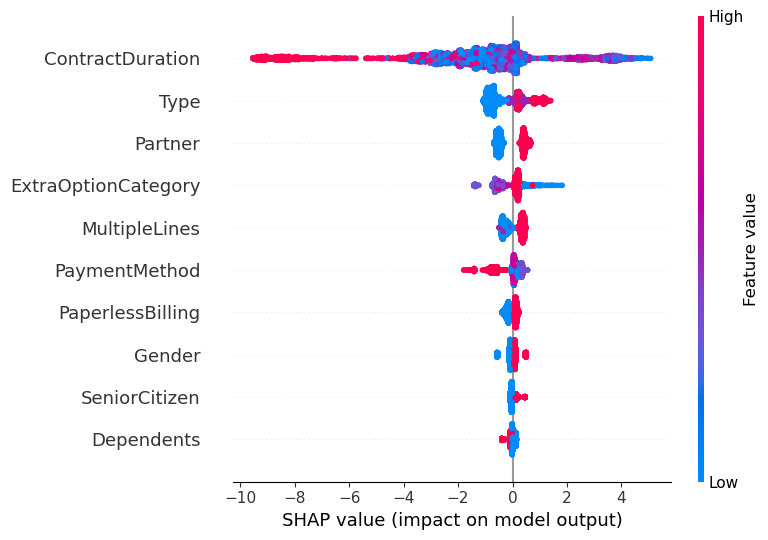

In [108]:
shap_test = shap.TreeExplainer(model_best).shap_values(oe_features_train)
shap.summary_plot(shap_test, oe_features_train, auto_size_plot=True)

Попробуем интерпретировать полученный график. 
* Можно заметить, что на графике выделяются те же четыре наиболее важных признака, что и при рассмотрении `feature_importances` выше: наиборее важный признак – длительность договора, далее с огромным отрывом следуют признаки 'Type', 'ExtraOptionCategory' и 'PaymentMethod'.
* Признак длительности договора оказывает наибольшее влияние на предсказание отрицательного класса: 0, "клиент не уйдет" (наиболее значимые наблюдения слева от вертикальной черты). Это соотносится с приведенными выше наблюдениями о распределении значений целевого признака относительно срока договора: на основании этого распределения были сделаны наблюдения, в какие сроки действия договора клиенты редко уходят (то есть с большей вероятностью остаются). 
* Какие-то значения признаков 'Type' и 'ExtraOptionCategory' более более значимы для прогнозирования положительного класса. Какие-то значения признака 'PaymentMethod', наоборот, более значимы для прогнозирования, останется ли клиент в компании.

**Выводы:**

* Осуществлена подготовка данных. Был создан категориальный признак, отражающий уровень активности клиента в пользовании дополнительными услугами в рамках пакетов. Из объединенной таблицы были выделены признаки для обучения и целевой признак. Данные разделены на обучающую и тестовую выборки в пропорции 3:1. Произведено кодирование признаков с учетом того, для каких моделей они готовятся. Для моделей, основанных на деревьях решений, и для бустингов категориальные признаки закодированы техникой порядкового кодирования, для логистической регрессии - техникой прямого кодирования. Отдельно оставлен набор признаков, в котором категориальные признаки не закодированы, но тип данных изменен на `category`. Эти признаки использовались для обучения моделей `LGBMClassifier`, а также предполагалось использовать для `CatBoostClassifier`, имена признаков параметру `cat_features`. Однако модель, обученная на таком наборе признаков, показала худший результат, чем на признаках, закодированных прямым кодированием, поэтому от использования для обучения модели `CatBoostClassifier` набора признаков, содержащего незакодированные признаки, было решено отказаться.
* Модели обучены на кросс-валидации c использованием `GridSearchCV`. Целевая метрика – AUC-ROC – нечувствительна к дисбалансу, поэтому при обучении можно было не использовать техники борьбы с дисбалансом (учет дисбаланса не влияет на результат, однако при обучении выбран вариант с его учетом). При этом для модели в качестве дополнительной метрики также рассчитывается чувствительная к дисбалансу Accuracy и анализируется матрица ошибок. По результатам анализа матрицы ошибок можно сделать вывод, что результаты модели, обученной с применением техники взвешивания классов, более адекватны задаче, поставленной заказчиком (прогнозировать уход клиентов).  Были рассмотрены следующие модели: `DesicionTreeClassifier`, `RandomForestClassifier`, `CatBoostClassifier`, `LGBMClassifier`, ` LogisticRegression`. На кросс-валидации лучший результат показала модель `CatBoostClassifier` с гиперпараметрами `{'depth': 2, 'iterations': 300, 'learning_rate': 0.5}`.
* Проведено тестирование лучшей модели. Значение целевой метрики AUC-ROC удовлетворяет условию – превышает пороговое значение 0.85. Дополнительно на тестовой выборке рассчитана метрика Accuracy, она составляет 0.89, это значение несколько выше результата для константной модели.
* Построена матрица ошибок и осуществлена ее интерпретация. Выявлено, что модель чаще дает ложноположительные, чем ложноотрицательные значения предсказаний. Это может привести к тому, что промокоды и специальные условия будут предложены, клиентам, которые в любом случае остались бы в компании.
* Осуществлена оценка важности признаков при помощи aтрибута  `feature_importances_` и средств библиотеки `shap`. Наиболее важными признаком является длительность договора. 

## Этап 3: Отчет

Ниже представлен отчет о работе над проектом, **целью** которого было на основании предоставленных заказчиком данных построить модель, которая позволит прогнозировать отток клиентов оператора связи «Ниединогоразрыва.ком» и вовремя и адресно предлагать промокоды и специальные условия для удержания клиентов.

### Ключевые шаги работы над проектом

Работа над проектом включала следующие **этапы**.

* **1 этап: планирование работы, предобработка и исследовательский анализ данных**  
  * **Загрузка и изучение данных**. Составление общего представления об объеме и качестве данных. Выявление проблем (несоответствующие типы данных, пропуски, дубликаты) и обозначение путей их решения.
  * **Предобработка данных**. Приведение данных к подходяцим типам, устранение ошибок, добавление столбцов, объединение таблиц, устранение пропусков.
  *  **Исследовательский анализ данных**. Анализ распределения признаков. Анализ распределения признаков в связи со значениями целевого признака. Рассмотрение корреляции признаков и борьба с коллинеарностью (устранение сильно коррелирующих признаков).
    
* **2 этап: подготовка данных к обучению, обучение и тестирование модели**
   *  **Подготовка данных к обучению**. Создание новых признаков и определение итогового набора признаков для обучения. Выделение признаков и целевого признаков. Разделение данных на обучающую и тестовую выборки. Кодирование признаков.   
  * **Обучение моделей и выбор лучшей модели**. Обучение моделей с различными гиперпараметрами. Оценка качества моделей на кросс-валидации и построение сравнительной таблицы, которая включает название модели, гиперпараметры, при которых модель показала лучший лучший результат (значение метрики `AUC-ROC`).
  * **Тестирование лучшей модели.** Вычисление значения метрики `AUC-ROC` и дополнительно `Accuracy` (+проверка на адекватность путем сравнения с константной моделью). Построение матрицы ошибок (`confusion_matrix`) и ее интерпретация. Сравнение значений дополнительных метрик для лучшей модели с учетом дисбаланса и без него. 
  * **Оценка важности признаков.**

* **3 этап: отчет по проекту**
  * **Подведение итогов проекта:** описание хода работы (в т.ч. предобработки данных, отбора признаков), анализ соответствия результатов плану, сравнение рассмотренных моделей, описание лучшей модели с гиперпараметрами и ее результат на тестовой выборке и т.д.).

### Соответствие фактической работы запланированным шагам

* Отклонением от первоначального плана работы над проектом стало создание **нового признака** `ExtraOptionCategory`, категоризирующего пользователей по **количеству дополнительных услуг**, подключенных в рамках пакетов. Этот признак коррелирует с признаком `MonthlyCharges` (ежемесячные траты), при этом позволяет при прочих равных несколько повысить итоговое значение целевой метрики и улучшить значения дополнительных метрик (`Accuracy` и результаты матрицы ошибок).
* Целевая метрика нечувствительна к **дисбалансу**, поэтому в первоначальном плане применение техники взвешивания классов не предполагалось. Однако в процессе работы выяснилось, что учет/неучет дисбаланса **влияет на дополнительные метрики**: повышает число **верных предсказаний ухода** клиента почти в два раза, но увеличивает количество случаев, когда модель предсказывает уход клиента, а в действительности он остается в компании. В качестве наилучшей модели предлагается модель, обученная с учетом дисбаланса.

### Сложности и пути их решения

В ходе работы было обнаружено, что **идентичные по качеству с точки зрения значения целевой метрики ROC-AUC варианты лучшей модели**, обученные с применением **техники взвешивания классов** и без нее, показывают существенные различия с точки зрения оценки результатов матрицы ошибок. Выбор оптимального варианта модели вызвал сложность, поскольку из условий задачи неизвестно, что в приоритете у заказчика: 1) **предотвратить уход большего числа клиентов**, рискуя при этом также предложить промокоды и специальные условия клиентам, которые не собираются уходить из компании, или 2) **допустить уход большего числа клиентов**, при этом избежав неадресного предложения промокодов и специальных условий. Поскольку явно обозначенная **цель проекта - предсказать уход** клиентов, более адекватными этой цели результатами при прочих равных мне представляются результаты модели, обученной с учетом дисбаланса. При этом считаю необходимым **ознакомить заказчика** с результатами тестирования обоих вариантов лучшей модели (обученной **с учетом дисбаланса и без него**).

### Итоговый список признаков, способы их обработки

* **Целевой признак**
    * `Churn` - факт ухода клиента из компании (1 – клиент ушел, 0 - клиент не ушел).
    
    
* **Признаки**
    * *Численный признак*
        * `ContractDuration` – длительность договора в днях до даты ухода (для ушедших) или до даты выгрузки (для действующих клиентов, случаи ухода из компании в дату выгрузки не обнаружены)       

    * *Категориальные признаки*
        * `Type` – тип оплаты (помесячный/ежегодный/раз в два года).
        * `PaperlessBilling` – электронный платежный документ (да/нет).
        * `PaymentMethod` - способ оплаты (электронный счет/почтовый счет/банковский перевод/кредитная карта)
        * `Gender` – пол (мужской и женский)
        * `SeniorCitizen` – наличие пенсионного статуса по возрасту (да/нет).
        * `Partner` – наличие супруга(и) (да/нет)
        * `Dependents` – наличие иждивенцев (да/нет)
        * `MultipleLines` – наличие возможности ведения параллельных линий по время звонка (да/нет)
        * `ExtraOptionCategory` – категория клиента по количеству подключенных дополнительных услуг в рамках пакетов (ни одной/одна/несколько/много)

**Численный** признак **масштабирован** при помощи `StandardScaler()` (раздельно для обучающей (`fit_transform()`) и тестовой (`transform()`) выборок).

**Категориальные** признаки преобразовывались тремя разными способами **для различных моделей**:
* *Порядковое кодирование* (`Ordinal Encoding`, раздельно для обучающей (`fit_transform()`) и тестовой (`transform()`) выборок) - использовано для моделей `DesicionTreeClassifier`, `RandomForestClassifier`, `CatBoostClassifier` (также можно использовать для `LGBMClassifier`).
* *Прямое кодирование* (`One-Hot Encoding`, раздельно для обучающей (`fit_transform()`) и тестовой (`transform()`) выборок) – использовано для модели `LogisticRegression`.
* *Преобразование* типа данных в `category` – использовано для модели `LGBMClassifier` (также можно использовать для `CatBoostClassifier`).

### Краткое описание предобработки данных

* В столбцах `BeginDate`, `EndDate`, `TotalCharges` и `SeniorCitizen` обнаружены неподходящие **типы данных**.
    * Данные в столбцах `BeginDate`, `EndDate` имели тип `object`, изменен на `datetime`. При этом в столбце `EndDate` для действующих клиентов `No` было заменено на дату выгрузки (это не привело к искажению данных – ни один клиент не ушел из компании в дату выгрузки).
    * Данные в столбце `TotalCharges` имели тип `object`, изменен на `float`, для этого "заглушки" в виде пробела для клиентов, заключивших договор в дату выгрузки, были заменены на размер ежемесячного платежа.
    * Данные в столбце `SeniorCitizen` имели тип `int` (целое число), изменен на `object`.
* Данные из предоставленных заказчиком четырех таблиц **объединены в одну таблицу**.
* В объединенной таблице **обработаны пропуски**, образовавшиеся в связи с тем, что в файлах `internet_new.csv` и `phone_new.csv`содержали данные не о всех пользователях. Пропуски в итоговой таблице означают, что клиент **не пользуется пакетом** в целом, поэтому они заменены на **новую категорию** `Not relevant`.
* В объединенной таблице **унифицированы названия** столбцов.
* На основании имеющихся данных **добавлены признаки** `Churn` (целевой показывающий, ушел ли клиент из компании), `ContractDuration` (длительность контракта в днях) и (позднее) `ExtraOptionCategory` (категория клиента по количеству подключенных дополнительных услуг в рамках пакетов).
* Заданы **списки численных и категориальных признаков** для обучения с учетом **борьбы с мультиколлинеарностью**, в результате которой в итоговый список признаков не вошли размер ежемесячной оплаты, общая сумма потраченных средств на услуги и все столбцы из исходной таблицы `internet_new.csv`

### Сводная таблица исследованных моделей и их метрика на кросс-валидации

На кросс-валидации были обучены следующие модели **классификации**: 
* `DesicionTreeClassifier` (дерево решений)
* `RandomForestClassifier` (случайный лес) 
* `CatBoostClassifier` (реализация градиентного бустинга)
* `LGBMClassifier` (реализация градиентного бустинга)
* `LogisticRegression` (логистическая регрессия) 

Ниже приведена таблица лучших значений метрики **AUC-ROC для перечисленных моделей на кросс-валидации** при помощи `GridSearchCV` (чем выше значение **AUC-ROC**, тем темнее цвет заливки соответствующей ячейки).

In [109]:
models_compared

,гиперпараметры лучшей модели,AUC_ROC
модель,,
DecisionTreeClassifier,"{'max_depth': 5, 'min_samples_leaf': 1}",0.804276
RandomForestClassifier,"{'max_depth': 6, 'min_samples_leaf': 5, 'n_estimators': 300}",0.827528
CatBoostClassifier,"{'depth': 2, 'iterations': 300, 'learning_rate': 0.5}",0.936862
LGBMClassifier,"{'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 300}",0.917243
LogisticRegression,"{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}",0.756140


### Лучшая модель (название, гиперпараметры, метрика на кросс-валидации)

Лучший результат на кросс-валидации показала модель `CatBoostClassifier` со значением **`AUC-ROC`**, равным **0.9369**. Гиперпараметры лучшей модели: `{'depth': 2, 'iterations': 300, 'learning_rate': 0.5}`. Модель обучена с учетом дисбаланса классов в целевом признаке – использовано значение параметра `auto_class_weights='Balanced'`.

### Итоговая метрика на тестовой выборке

Модель, показавшая лучший результат на кросс-валидации, – `CatBoostClassifier` c гиперпараметрами `{'depth': 2, 'iterations': 300, 'learning_rate': 0.5}` независимо от использования/неиспользования параметра `auto_class_weights='Balanced'`, на тестовой выборке показывает значениe целевой метрики **`AUC-ROC` 0.9324**, что удовлетворяет условию задачи, согласно которому итоговое значение целевой метрики на тестовой выборке должно быть **выше 0.85** (но ниже 0.95). Данное значение метрики можно визуально представить на графике ROC-кривой (значение `AUC-ROC` - это площадь под кривой, отношение доли ложноположительных ответов (`False Positive Rate`) к доле истинно положительных ответов (`True Positive Rate`), пунктирная линия показывает результат **случайной модели**, значение `AUC-ROC` для которой составляет **0.5**). 

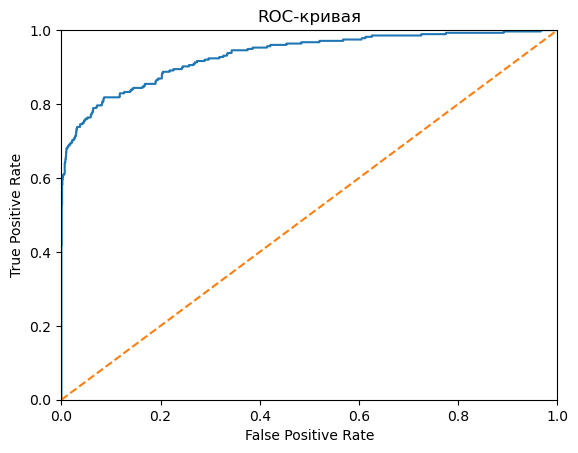

Дополнительно для заказчика была посчитана метрика `Accuracy`, показывающая общую долю правильных предсказаний модели на тестовой выборке, но не показывающая, насколько успешно модель предсказывает положительный класс ("клиент ушел") и отрицательный класс ("клиент клиент остался"). Для лучшей модели, обученной с учетом дисбаланса классов, значение **`Accuracy`** на тестовой выборке составляет **0.8932** (89.32% правильных ответов). Также произведено **сравнение** полученной `Accuracy` **с результатом константной модели**: `Accuracy` константной модели на тестовой выборке составляет **0.8438.**

**Сравнение значений метрик `AUC-ROC` и `Accuracy`** на тестовой выборке для **лучшей на кросс-валидации и константной (`DummyClassifier`) моделей** представлено в таблице.

In [110]:
best_vs_dummy

,CatBoostClassifier,DummyClassifier
метрика,,
AUC_ROC,0.9324,0.5000
Accuracy,0.8932,0.8438


Лучшая подобранная на кросс-валидации модель показывает лучшие результаты, чем константная модель, то есть ее результаты не могут быть получены случайно.

### Анализ матрицы ошибок

**Матрица ошибок** показывает количество значений обоих классов целевого признака ("клиент ушел"/"клиент не ушел"), которые **лучшая модель предсказала правильно или неправильно на тестовой выборке**.

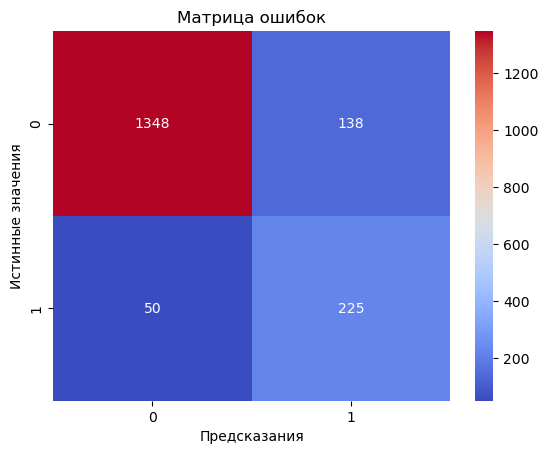

Для удобства также представим матрицу ошибок в долях от общего объема тестовой выборки.  

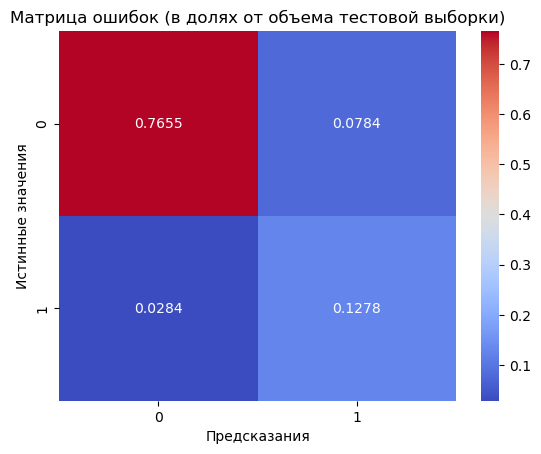

Всего тестовая выборка содержит данные о **1761 клиенте**, **275** из которых **ушли** из компании и **1486 остались** (есть значительный дисбаланс классов). По главной диагонали (от верхнего левого угла) матрицы расположены **правильные ответы**, в сумме составляющие **89.32%** от всей выборки (это и есть значение `Accuracy`). 
В матрице ошибок представлены ответы четырех типов:
* **Истинно положительные ответы** (`True Positive`): модель правильно предсказала, что клиент уйдет. 225 ответов, 12.78% от всей выборки, 81.81% от всех истинных значений положительного класса.
* **Истинно отрицательные ответы** (`True Negative`): модель правильно предсказала, что клиент не уйдет. 1348 ответов, 76.55% от всей выборки, 90.71% от всех истинных значений отрицательного класса.
* **Ложноположительные ответы** (`False Positive`): модель предсказала, что клиент уйдет, но он не ушел. 138 ответов, 7.84% от всей выборки, 9.29% от всех истинных значений отрицательго класса.
* **Ложноотрицательные** (`False Negative`): модель предсказала, что клиент не уйдет, но он ушел. 50 ответов, 2.84% от всей выборки, 18.18% от всех значений истинных положительного класса.

Модель правильно предсказала уход в 81.81%  случаев (225 клиентов) и не предсказала уход 18.18% от всех ушедших клиентов  (50 клиентов). В 138 случаях (9.29% всех клиентов, которые не ушли) модель предсказала уход клиентов, которые на самом деле остались. При прогнозировании ухода клиентов из компании такие ложноположительные результаты приведут к тому, что промокоды и специальные условия будут предложены клиентам, которые и так остались бы в компании.

### Важность признаков

Важность признаков определялась при помощи атрибутa `feature_importances_` лучшей модели. 

**Наиболее важным** для модели является признак **`ContractDuration`** со значимостью более 90%. На остальные признаки приходятся оставшиеся 9.5%: среди этих признаков выделяются `Type` и  `ExtraOptionCategory`. На четвертом месте признак `PaymentMethod`.

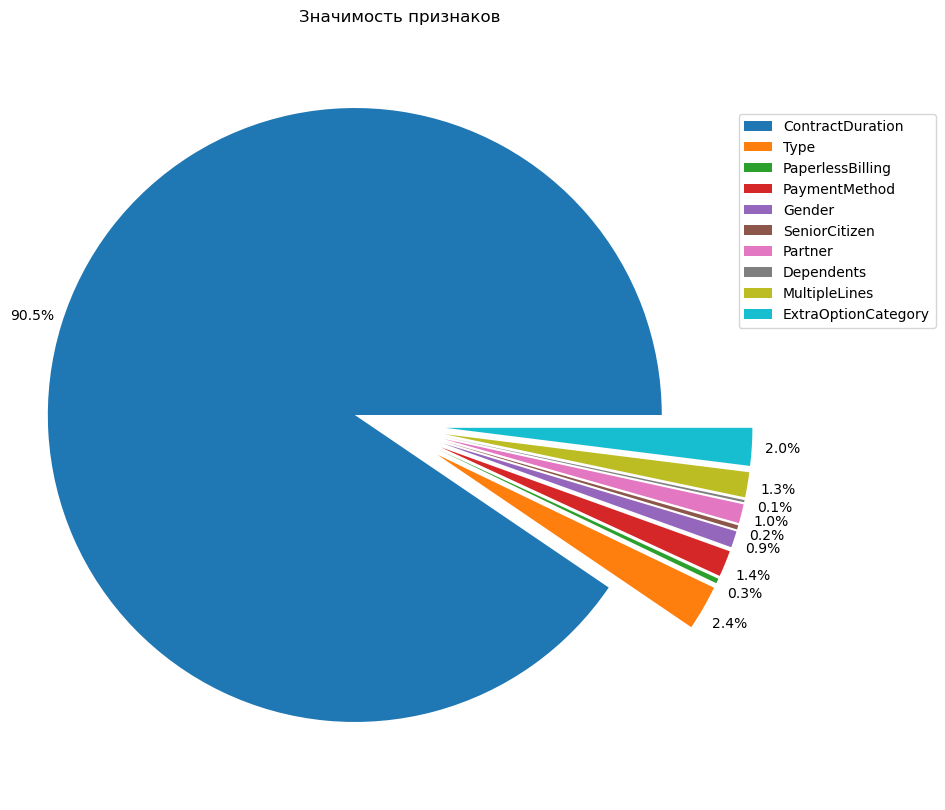

Второй способ оценки важности признаков - средства библиотеки `shap`. Представленный ниже график показывает не только значимость признаков для обученной на них модели модели, но и то, как они влияют на прогнозирование классов.

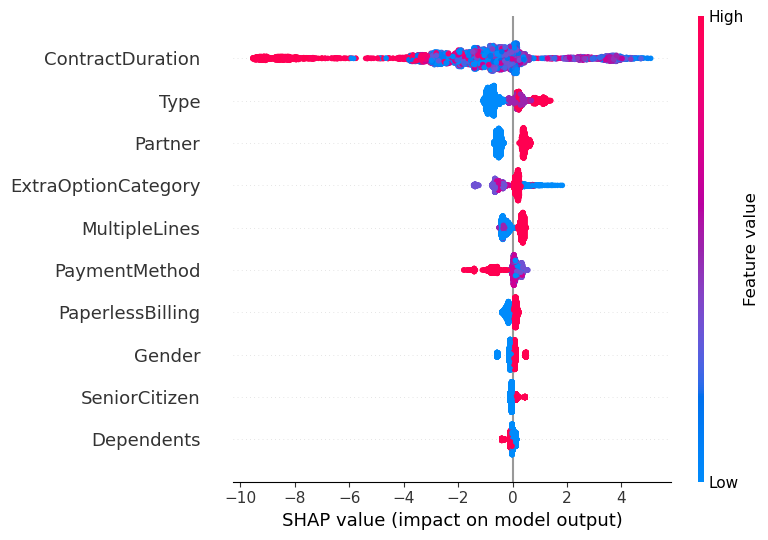

Попробуем интерпретировать  график. 
* На графике выделяются те же четыре наиболее важных признака, что и при рассмотрении `feature_importances_` выше: наиборее важный признак – длительность договора, далее с огромным отрывом следуют признаки `Type`, `ExtraOptionCategory` и `PaymentMethod`.
* Признак длительности договора оказывает наибольшее влияние на предсказание отрицательного класса: 0, "клиент не уйдет" (наиболее значимые наблюдения слева от вертикальной черты). 
* Какие-то значения признаков `Type` и `ExtraOptionCategory` более более значимы для прогнозирования положительного класса ("клиент уйдет"). Какие-то значения признака `PaymentMethod`, наоборот, более значимы для прогнозирования, останется ли клиент в компании.

### Дополнительно: влияние борьбы с дисбалансом на дополнительные метрики (требует внимания заказчика)

Выше представлены результаты наилучшей модели, обученной **с учетом дисбаланса классов**. При одинаковом значении целевой метрики `ROC-AUC` на тестовой выборке (**0.9324**), значения **`Accuracy` и результаты матрицы ошибок будут различаться** у модели с одним набором гиперпараметров при использовании и неиспользовании техники взвешивания классов.

Значение `Accuracy` на тестовой выборке для модели, обученной без учета дисбаланса, выше (**0.9432**): модель дает верные предсказания в **94,32%** (в сопоставлении с **89.32%** для модели, обученной без учета дисбаланса). 

Посмотрим на результаты матрицы ошибок. 

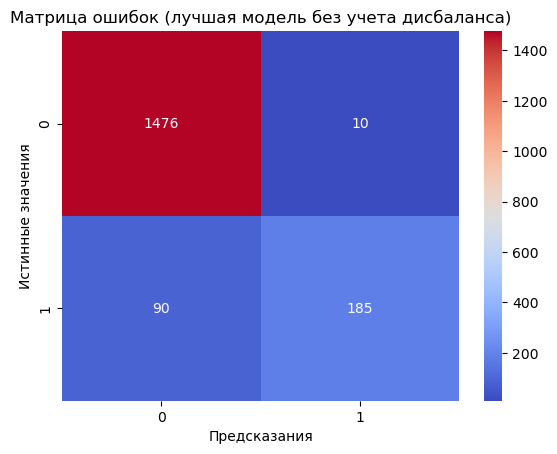

Представим данную матрицу также в долях от общего объема тестовой выборки.

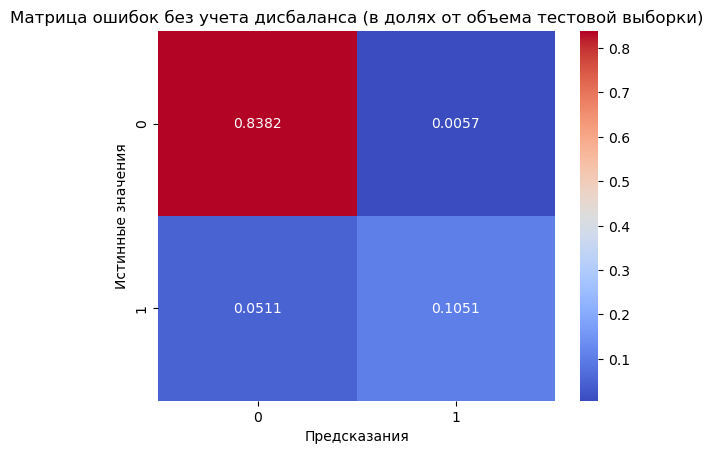

Распределение ответов в матрице ошибок:
* **Истинно положительные ответы** (`True Positive`): модель правильно предсказала, что клиент уйдет. 185 ответов, 10.51% от всей выборки, 67.27% от всех истинных значений положительного класса.
* **Истинно отрицательные ответы** (`True Negative`): модель правильно предсказала, что клиент не уйдет. 1476 ответов, 83.82% от всей выборки, 99.33% от всех истинных значений отрицательного класса.
* **Ложноположительные ответы** (`False Positive`): модель предсказала, что клиент уйдет, но он не ушел. 10 ответов, 0.57% от всей выборки, 0.67% от всех истинных значений отрицательго класса.
* **Ложноотрицательные** (`False Negative`): модель предсказала, что клиент не уйдет, но он ушел. 90 ответов, 5.11% от всей выборки, 32.73% от всех значений истинных положительного класса.

Несмотря на то, что значение `Accuracy` модели, обученной без учета дисбаланса, выше, положительный класс она предсказывает хуже: модель показывает ложноотрицательный результат в 90 случаях из 275 (32,73% от всех ушедших клиентов), при этом число ложноотрицательных ответов ничтожно мало – всего 10 - промокоды и специальные условия практически не будут предлагаться клиентам, которые и так останутся в компании. При прочих равных результаты модели с учетом дисбаланса классов, по моему мнению, более адекватны поставленной заказчиком задаче (**предсказать уход клиентов**), однако считаю необходимым ознакомить заказчика с обоими вариантами и хотела бы **порекомендовать оценить возможную упущенную выгоду от ухода клиента и от предложения промокодов и специальных условий клиентам, которые на самом деле не собираются уйти из компании**. 